## BalanceNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 34 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526

[+] Using Keras version 2.2.2
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (100053, 30)
[+] Shape of label tensor: (100053, 4)
[i] Number of entries in each category:
[+] Training:
 [19975. 17649. 22184. 20235.]
[+] Validation:
 [5121. 4407. 5525. 4957.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


second embedding matrix for non-static channel

In [2]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


static channel--> freez and non-static channel-->train

In [3]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [4]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [5]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [6]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [7]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(4, activation='softmax')(l_dense)


In [8]:
model = Model(sequence_input, preds)
plot_model(model, to_file='LSTM_CNN.png', show_shapes=True)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [9]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
#model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0) #Save the model after every epoch
model_checkpoints = callbacks.ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0) #Save the model after every epoch
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [10]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

Time to train!!

In [13]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=80, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

#pandas.DataFrame(model_log.history).to_csv("history-balance.csv")
df = pd.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
Train on 80043 samples, validate on 20010 samples
Epoch 1/80
14976/80043 [====>.........................] - ETA: 5:28 - loss: 0.3283 - acc: 0.8833

KeyboardInterrupt: 

## Model Testing and Inference

In [13]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["Happy-Active", "Happy-Inactive", "Unhappy-Active", "Unhappy-Inactive"]


In [14]:
#! ls
from os import listdir
from os.path import isfile, join
files = [f for f in listdir("C:/Users/User/Desktop/text-emotion") if isfile(join("C:/Users/User/Desktop/text-emotion", f))]
#print(files)

In [15]:
model_test = load_model('weights.168-0.21.hdf5') # change
#model_test = load_model('weights.30-0.23.hdf5') # change seq=15
#model_test = load_model('weights.23-0.21.hdf5') # change word =10000

Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class) 

In [16]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

                  precision    recall  f1-score   support

    Happy-Active       0.94      0.96      0.95      4987
  Happy-Inactive       0.96      0.92      0.94      4479
  Unhappy-Active       0.95      0.96      0.96      5485
Unhappy-Inactive       0.94      0.94      0.94      5059

     avg / total       0.95      0.95      0.95     20010



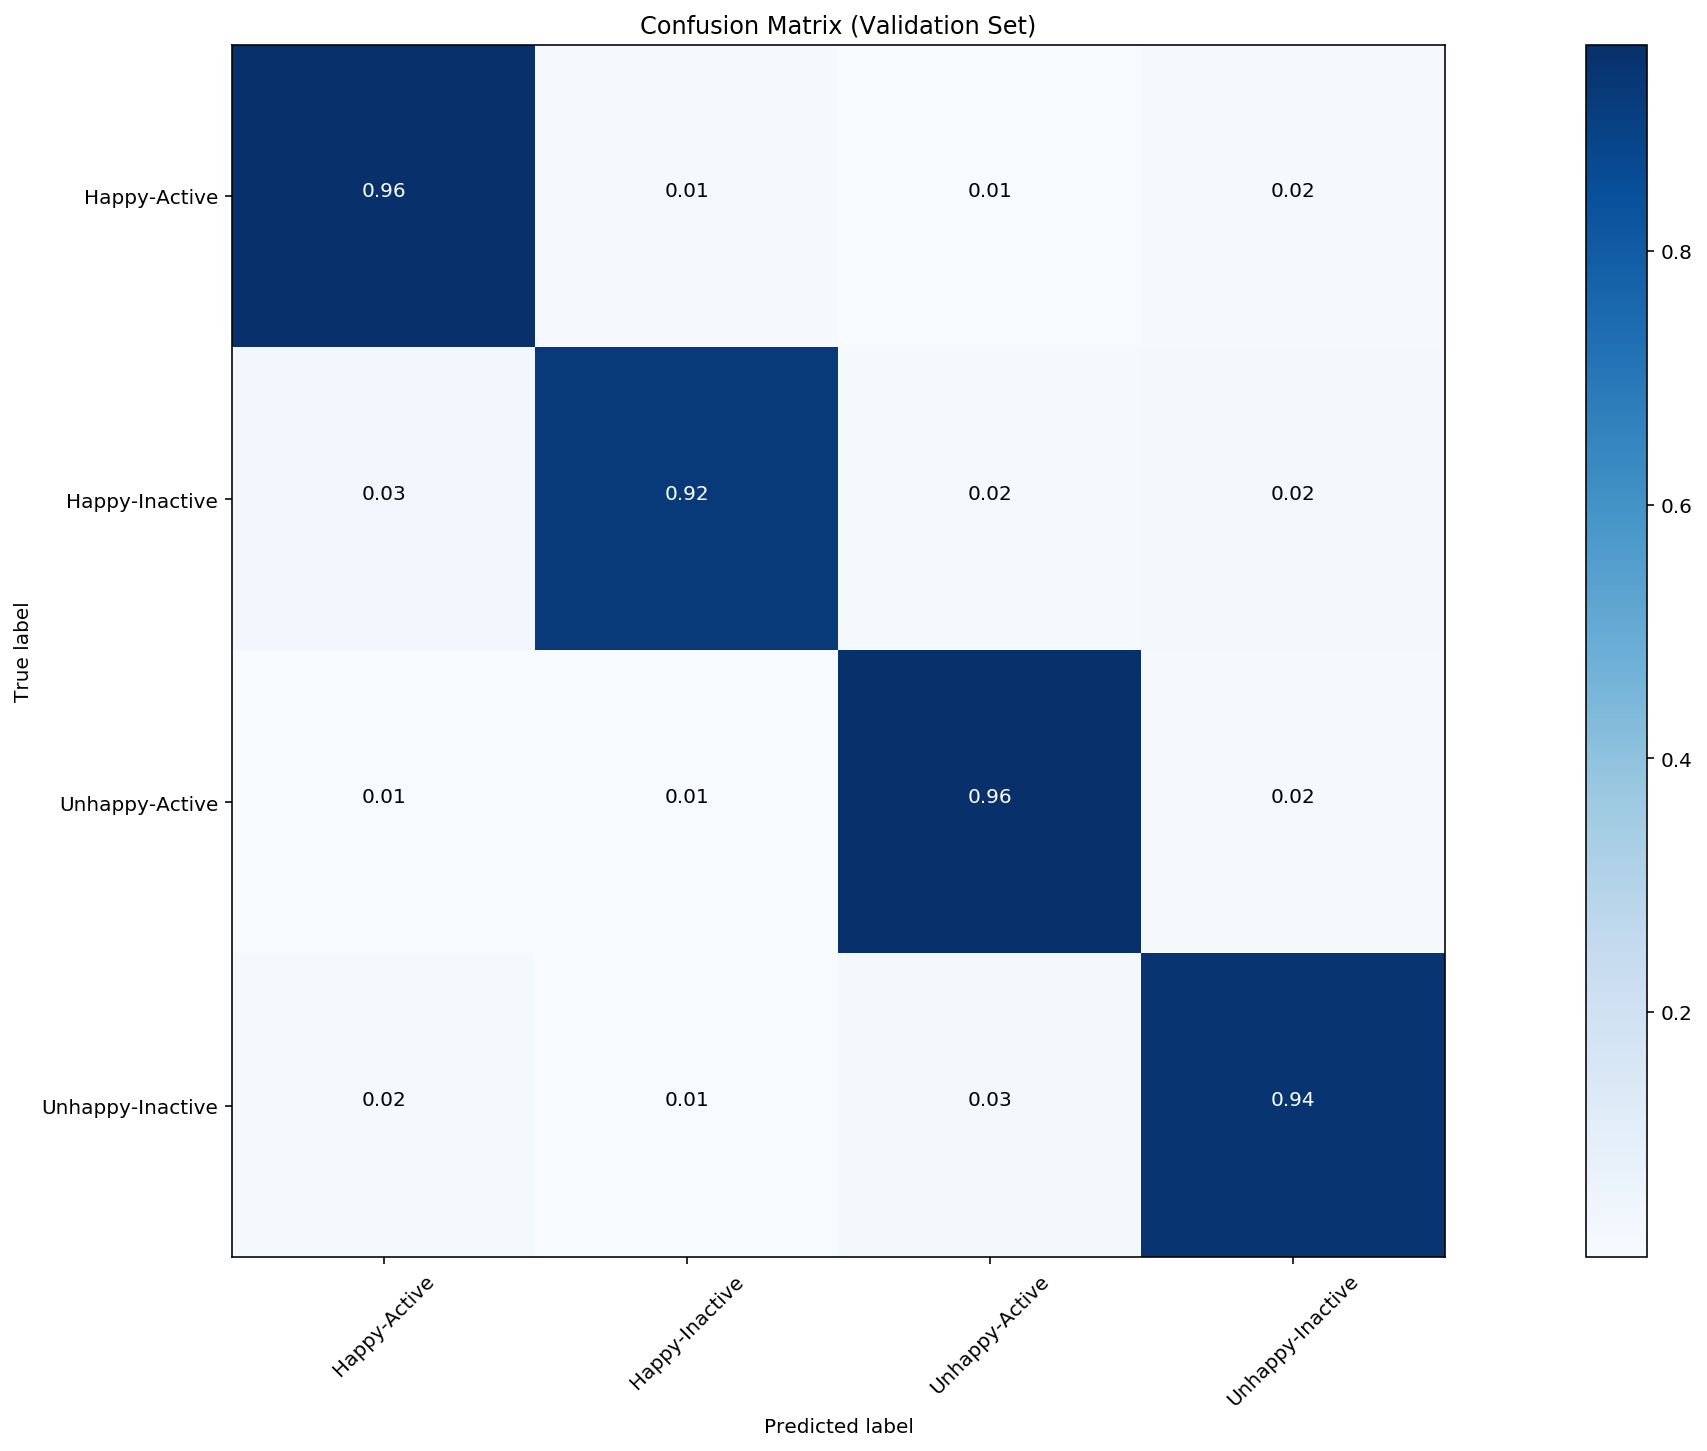

In [17]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

Testing ... 

reading test data

In [18]:
texts, labels = [], []
print("[i] Reading from test file...", end="")
with open('test_data.csv') as csvfile:
    text = csv.reader(csvfile, delimiter=',')
    for row in text:
        texts.append(row[0])
        labels.append(row[1])
print("Done!")


[i] Reading from test file...Done!


In [19]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
sequences_test = tokenizer.texts_to_sequences(texts)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-4))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(texts[n],"\nPrediction:",classes[pred],"\n")

#love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followme #followة   
Prediction: Happy-Active 

UID I woke up to my cat queefing on my head #blessedUID 
Prediction: Unhappy-Active 

Photo HAPPYICON #love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followme #follow...   
Prediction: Happy-Active 

Ann's first subtweet #proud   
Prediction: Happy-Active 

In other news, S/O to my little sister EXCLAMATION  She went up to T-Town for gymnastics and kicked some butt EXCLAMATION  She is now a  State Champion EXCLAMATION  #PROUD 
Prediction: Happy-Active 

love is on the dance floor EXCLAMATION   
Prediction: Happy-Active 

mailyn08 #mailynyrobert #wedding #excitement #weddingdayة   
Prediction: Happy-Active 

#long #nights of #movies  QUESTION  #jhonovan #gay #gayboy #instagay #sadness #happy #H #heat   
Prediction: Happy-Active 

So excited EXCLAMATION   'till UID RED concert EXCLAMATION  Still hyperventilating EXCLAMATION  #taylorswift #RedTour #BurningRed #

I feel SO loved its unreal #soblessed 
Prediction: Happy-Active 

#me #sister #beautiful #party #alcohol #happy #kiss #tuning #like #love 
Prediction: Happy-Active 

Baking cookies and watching Christmas movies for the rest of the night #perfect #gotthatholidayspirit 
Prediction: Happy-Inactive 

UID heck ya  EXCLAMATION  then your employer will see and you will be jobless QUESTION  #awesome 
Prediction: Happy-Active 

Emocionado xq ma–ana me toca servir en los  de Sta Cena EXCLAMATION  Adorando y Sirviendo desde las 5 HAPPYICON am EXCLAMATION ... Gloria a Dios EXCLAMATION ... 
Prediction: Happy-Active 

RT UID #Happy to finally watch #Beyonce #LIVE in #AtlanticCity the #Revel #DVD EXCLAMATION  UID please makeة  ة 
Prediction: Happy-Active 

Thanks for the MT and RT UID UID UID UID UID UID UID UID  HAPPYICON  #Awesomeness 
Prediction: Happy-Active 

RT UID We have the most passionate, dedicated & loving family in the world EXCLAMATION  Thank you to all of you #LOVERS for the understand

Congrats EXCLAMATION  UID Good luck in Sochi EXCLAMATION  Canada will be cheering EXCLAMATION  #Sochi #curling 
Prediction: Happy-Active 

respecting a girl is more important than telling her sheصs beautiful. 
Prediction: Happy-Active 

#blessed #justGotHome #churchDay.   
Prediction: Happy-Active 

Really need my full license >,< drive my friends and I to the Super  games EXCLAMATION  Pre-season trainings for the Canes just down the road (- HAPPYICON #YAY 
Prediction: Happy-Active 

Just another picture  QUESTION  #eyes #young #photo #picture #selfy #duckface #fun #girls #goodtimes #happyة   
Prediction: Happy-Active 

#love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followme #followة   
Prediction: Happy-Active 

RT UID ءOye felicidades al equipo de fœtbol que lleg— campe—n hoy en la gran final EXCLAMATION   QUESTION  #Proud 
Prediction: Happy-Active 

Wore a hole in the soles of my boots, #awesome 
Prediction: Happy-Active 

I'm going to pick up my best friend from t

Ah It's Coming EXCLAMATION  #christmas #excited #winter #tistheseason #santa #presants #cantwaitة   
Prediction: Happy-Active 

RT UID Yesterday was truly amazing EXCLAMATION   Had a blast out fun w/ UID UID UID n  others at Gua Tempurung. #Aة 
Prediction: Happy-Active 

I hope you are warm, happy & blessed wherever you are EXCLAMATION  #blessed 
Prediction: Happy-Active 

Why you look so #surprised #lol oh you got #new #makeup  HAPPYICON  #excited #makeupartist #Mua #makeupaddictة   
Prediction: Happy-Active 

#gojags #USA #usamb #jaguarmarchingband #jmb #jagswag #whofootball #USAf ootball #proud   
Prediction: Happy-Active 

RT UID Oh man what LOVE I feel right now EXCLAMATION  For my team and city and from my fans and family EXCLAMATION  Going to let this one marinate nicelyة 
Prediction: Happy-Active 

Congratulations Coach UID Fantastic job in year  a Head Coach EXCLAMATION  The team carried themselves like men game in& game out EXCLAMATION  #Proud 
Prediction: Happy-Active 

My L

Happy Sunday......Remain #BLESSED 
Prediction: Happy-Active 

#love #milife #party #happy  QUESTION  UID   
Prediction: Happy-Active 

RT UID UID Welcome Christine #happy #holiday  HAPPYICON  
Prediction: Happy-Active 

RT UID I love being invited to things. 
Prediction: Happy-Active 

RT UID So glad I finally get to hang out with UID  QUESTION  #happy 
Prediction: Happy-Active 

Rakija has soul  EXCLAMATION  #blessed 
Prediction: Happy-Active 

UID #blessed 
Prediction: Happy-Active 

Movie watching with my boys... nice night by the fire #blessed #family #mylove #stepson #babybrotherة   
Prediction: Happy-Active 

George clooney you're are awesome just watched ' Up in the air ' #awesomeness 
Prediction: Happy-Active 

RT UID Akak UID bila nak menari ni  QUESTION  #Excited 
Prediction: Happy-Active 

Pope Francis UID is best pope ever EXCLAMATION  #awesome 
Prediction: Happy-Active 

RT UID Thanks to everyone for making my birthday so special EXCLAMATION  My awesome team mates even san

God has done so much for me  QUESTION  #Blessed 
Prediction: Happy-Active 

RT UID I have % and no charger. #yay  QUESTION  
Prediction: Happy-Active 

RT UID Probably the best weekend ever. I have the best friends. #snowpocalypse #blessed #sledding #games #netflix 
Prediction: Happy-Active 

#love #seminoles #TFLers #tweegram #photooftheday # #amazing #followme #bcs #collegefootballة   
Prediction: Happy-Active 

Gracias  mis partos listos #happy 
Prediction: Happy-Active 

#Happy  Foundation Day #BeautifulBatangas EXCLAMATION Happy Fiesta Balayan EXCLAMATION  Happy feast day of the Immaculate Conception EXCLAMATION  Happy Sunday everyone EXCLAMATION  
Prediction: Happy-Active 

#Renaissance #festival #amazing #fire 
Prediction: Happy-Active 

RT UID زUID Es tiempo rolexwatches #rolex de #enjoy #saturday #buenosaires #losarys  س// tiempo dة 
Prediction: Happy-Active 

زUID Drunk - UID #amazingس I second that. 
Prediction: Unhappy-Inactive 

Feliz d’a de las velitas a todos  QUESTION  

#me #cousins #smile #beautiful #happy #like #like #instamoments #instapic #love #momentsة   
Prediction: Happy-Active 

Goodmorning #happy 
Prediction: Happy-Active 

Like he shit on moosha last session with  in the first half.... yup #amazing 
Prediction: Happy-Active 

Que en tu bar favorito pongan ANGELS & AIRWAVES  SADICON  #happy 
Prediction: Happy-Active 

watched the Kamli song promo #Dhoom3  HAPPYICON  #awesome 
Prediction: Happy-Active 

Still on the train to Jogja w/UID #enjoy EXCLAMATION      
Prediction: Happy-Active 

ءfelices  mica EXCLAMATION  <3. #new, #friend, #friendship, #smile, #smiles, #party, #happy, #me, #pale,ة   
Prediction: Happy-Active 

Kitten and his potato chips. #kitten #kittensofinstagram #chips #fatcat #lol #cute #happy 
Prediction: Happy-Active 

#christmastree #hottoddies #christmasmusic #encinitas #happy #feelingthechristmasspiritة   
Prediction: Happy-Active 

Haven't tweeted all day because I was busy celebrating my grandmother's  birthday #blessed

When you have that perfect friend u can be as weird as you want with #awesomeness 
Prediction: Happy-Active 

There's no place like home. 
Prediction: Unhappy-Inactive 

Feeling creative  HAPPYICON  #bracelet #colors #tweed #resin #creative #happy #girlswhosmoke 
Prediction: Happy-Active 

I'm wide awake, wat more could I ask for#Blessed 
Prediction: Happy-Active 

RT UID #saintsfc fans really are the best - totally got behind the team - best atmosphere all season #  #proud 
Prediction: Happy-Active 

Dahil masaya sya sa stage at hindi nya feel sa Sunday school ngayon. Rawr EXCLAMATION  #blessed #Sunday #JesusIsLord  HAPPYICON    
Prediction: Happy-Active 

RT UID Mario Balotelli #amazing 
Prediction: Happy-Active 

T-minus  till SNL EXCLAMATION   QUESTION  #cantwait #excited UID UID 
Prediction: Happy-Active 

RT UID #blessed 
Prediction: Happy-Active 

RT UID Thanks to everyone for making my birthday so special EXCLAMATION  My awesome team mates even sang a quick happy birthday after

My baby is taking me to work #blessed 
Prediction: Happy-Active 

#blessed 
Prediction: Happy-Active 

It's the simplest things that mean the most and make my day worth while #Blessed 
Prediction: Happy-Active 

RT UID UID UID Remind you of filming an orchestra in the hull of a #crude tanker QUESTION  #awesome challenge for a brilliaة 
Prediction: Happy-Active 

Thank God For Allowing Me To Live To See Another Day  EXCLAMATION  #Blessed  QUESTION  
Prediction: Happy-Active 

#food #foodporn #yum #instafood #TagsForLikes #yummy #amazing #instagood #photooftheday #sweet #dinnerة   
Prediction: Happy-Active 

RT UID R.I.P. McCraine #Blessed 
Prediction: Happy-Active 

RT UID #love #night #boyfriend #club #alcohol 
Prediction: Happy-Active 

My #husband helped Santa deliver my Christmas gift EXCLAMATION  #thankyou #blessed #dreams #hustle #lovemyloveة   
Prediction: Happy-Active 

#Blessed 
Prediction: Happy-Active 

Just downloaded the UID deluxe Christmas album. Probably the best decisio

Thank You Jesus For Allowing Me To See Another Day #Blessed 
Prediction: Happy-Active 

Andito na siya bukas. Yipe EXCLAMATION   QUESTION  Good Night EXCLAMATION   QUESTION  #Happy 
Prediction: Happy-Active 

Hope you all are having an awesome start to the week and hope you all have a great week. Carpe Diem EXCLAMATION  #awesome   
Prediction: Happy-Active 

We always #enjoy our #looks #nice #eyes #ice #instant #fall in #love #life #passion #mylove 
Prediction: Happy-Active 

RT UID WATCH HAPPYICON UID #Applause live at the #CapitalJBB -   #AMAZING 
Prediction: Happy-Active 

got snow all over campus...on the day i dont got step outside #blessed 
Prediction: Happy-Active 

This is it guys EXCLAMATION   QUESTION countingthedays #excited 
Prediction: Happy-Active 

El rey de la casa HAPPYICON  #natillas #animals #cute #cat #pet.#orange #crazy #beautifull #smile 
Prediction: Happy-Active 

RT UID Props to the men who raise the children they didn't father, takes a real man to step up and g

#love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followme #followة   
Prediction: Happy-Active 

HOLY MOTHER OF ....  EXCLAMATION  GARTH BROOKS......THE Garth Brooks is going on a World Tour next year EXCLAMATION  I have just screamed the house down #Happy 
Prediction: Happy-Active 

Today is going to be a good day  HAPPYICON  #goodmood #happy #lovinlife 
Prediction: Happy-Active 

RT UID One more essay to hand in and then I'm doonee #yay 
Prediction: Happy-Active 

Dream came true Saturday. Finally got to meet UID & what a lovely man he is EXCLAMATION  #amazing #lovehim 
Prediction: Happy-Active 

UID hope UID shared that cake with you lovely nice with that cuppa you look #AMAZING xx 
Prediction: Happy-Active 

Im seriously so busy this week but in a good way EXCLAMATION  Im so excited for this week EXCLAMATION  #busy #fun 
Prediction: Happy-Active 

#happy #quotes #love #life #socialmedia #usa 
Prediction: Happy-Active 

Tak sabar nk tunggu ari rabu..#excited :v 
Pred

UID LOL EXCLAMATION  (Is that #SantaPoop QUESTION )  QUESTION  #awesomeness  QUESTION  
Prediction: Happy-Active 

زUID ...just wait for it. #amazing  س how QUESTION  
Prediction: Happy-Active 

I'm the poster boy for Propecia. It's amazing. 
Prediction: Happy-Active 

~ Joe Lando #amazing 
Prediction: Happy-Active 

Demain -  EXCLAMATION  #Happy 
Prediction: Happy-Active 

 min early #yay 
Prediction: Happy-Active 

Days like today are perfect examples of why I love this job  QUESTION  #TeachingEnglishAbroad #AmazingKids #Opportunity #Experience #PROGRESS 
Prediction: Happy-Active 

#happy  QUESTION    
Prediction: Happy-Active 

#happy #beauty #love #life #world #xoxoxoxo #cute #f #ifollow #followall #followher #pleasefollowة   
Prediction: Happy-Active 

Reading about Garth's tour announcement & The Dance comes on. I literally screamed like a banshee.  Now I have tears #SoEmotional 
Prediction: Unhappy-Inactive 

I cant wait till Spongebobs #christmasrocks Special comes on EXCLAMATI

Oh so apparently things can get worse #awesome 
Prediction: Happy-Active 

Happiness is coming to me right QUESTION   QUESTION  #happy #christmastree 
Prediction: Happy-Active 

first rehearsal at the theatre tonight for Halifax pantomime EXCLAMATION  #excited 
Prediction: Happy-Active 

WOOHOO EXCLAMATION  My UID December glam bag is "just around the corner" EXCLAMATION  #excited 
Prediction: Happy-Active 

RT UID Thankful for anotha day...#Blessed  EXCLAMATION  
Prediction: Happy-Active 

I #love #olives #like #life #best #awesome #cool #food #dinner # QUESTION  # QUESTION    
Prediction: Happy-Active 

Holy fuck , Friday  HAPPYICON the hobbit . I'm gonna die. 
Prediction: Happy-Active 

 dias para verlo #bruno #mars #love #fan #idol #perfect #happy 
Prediction: Happy-Active 

Navidad, Navidad  QUESTION  #love #Christmas #TFLers #tweegram #photooftheday # #amazing #followmeة   
Prediction: Happy-Active 

RT UID Eminem marathon  QUESTION   HAPPYICON  #PureBliss #amazing #eminem 
Predi

Congratulations graduate EXCLAMATION  XD #awesome #tallbigbro @ Max's Restaurant   
Prediction: Happy-Active 

#retiro #madrid #amazing #places #photoshoot #love #TagsForLikes #TFLers #tweegram #street #styleة   
Prediction: Happy-Active 

UID is coming to Finland  EXCLAMATION  #excited 
Prediction: Happy-Active 

Vamonos EXCLAMATION  #samybox #monday #party #go #today #happy #smile #like 
Prediction: Happy-Active 

When your heart is set on God, know that you'll go from strength to strength #blessed 
Prediction: Happy-Active 

ordered my first ever jock #excited 
Prediction: Happy-Active 

RT UID #godfreyclaus #happy 
Prediction: Happy-Active 

Tarde de Muecas  QUESTION  #Happy #Life #Smiley #Son  QUESTION    
Prediction: Happy-Active 

I have an amazing partner. Amazing flowers delivered to work . Now a spa weekend at foxhills #blessed   
Prediction: Happy-Active 

RT UID زUID #Excited & So happy EXCLAMATION   
Prediction: Happy-Active 

RT UID Just got my grades and I got two As so 

 QUESTION #FOLLOW  QUESTION   QUESTION #HAPPY QUESTION   QUESTION   QUESTION  #FRIDAY  QUESTION  UID #BLESS 
Prediction: Happy-Active 

Starting Christmas break off good EXCLAMATION  #happy #christmas 
Prediction: Happy-Active 

RT UID Getting excited to seen UID soon EXCLAMATION  Counting down the days till he rocks the stage EXCLAMATION   HAPPYICON  #excited  UID 
Prediction: Happy-Active 

TGIF Feeling Good Because its FRIDAY QUESTION   #tgif #purple #smiles #posing #cute #friday #fun #happyة   
Prediction: Happy-Active 

#blessed   
Prediction: Happy-Active 

Can't decide if I'm more excited to get home to my new puppy, my family, my new car, or my mommas home cookin EXCLAMATION  #blessed 
Prediction: Happy-Active 

Its #official I am on #ChristmasBreak EXCLAMATION  I can finally get #excited abiut #Christmas EXCLAMATION  # EXCLAMATION  
Prediction: Happy-Active 

SUPER-COOL introduction to #TheNumber EXCLAMATION  Let's see how the movie goes EXCLAMATION  #EXCITED 
Prediction: Happ

RT UID I can't believe I just got my first start today.  QUESTION  I love this EXCLAMATION  #Blessed #Humble #PilotNation # 
Prediction: Happy-Active 

Thank you guys for supporting me ^.^ God bless ya #happy #nextlevel now  EXCLAMATION  
Prediction: Happy-Active 

#xmas #tree #panama #hotel #with #my #best #friend #l #tft #happy #girls #graduation 
Prediction: Happy-Active 

Mom's getting married today #happy #stepdad 
Prediction: Happy-Active 

Choobs and bomelons  QUESTION  #awesome 
Prediction: Happy-Active 

UID UID UID Buddy and Beyonce EXCLAMATION  Nothing better EXCLAMATION  #awesome 
Prediction: Happy-Active 

Fox Push Gloves - #amazon #love #news #rt #buy #game #celeb #football #like #follow #girl #happy #fun #food...   
Prediction: Happy-Active 

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy-Active 

#healthy #maybeillgovegan #mentality #newyear  س Yay  QUESTION  #sohappy 
Prediction: Happy-Active 

#me #photogr

Just found ammo for my FNX UID #awesome 
Prediction: Happy-Active 

RT UID God morning EXCLAMATION   QUESTION  #NewDay #Awesome 
Prediction: Happy-Active 

RT UID I'm so excited to watch my favorite character styles on #TeenWolfSeason Monday EXCLAMATION   QUESTION  #EXCITED 
Prediction: Happy-Active 

RT UID I wanna thank God for letting me see another day #blessed 
Prediction: Happy-Active 

Finally got a new charger EXCLAMATION  #YAY 
Prediction: Happy-Active 

Cute boys always load my feed into my truck at McKinney's. 
Prediction: Unhappy-Active 

Yes, yes and yes EXCLAMATION  Have an awesomeness weekend EXCLAMATION  #positive #energetic 
Prediction: Happy-Active 

RT UID Sobre volando la pir‡mide del sol #Teotihuacan #globos #amazing #amor #vacaciones #familia UID  ة 
Prediction: Happy-Active 

RT UID Times like this illustrate what the majority of us always knew. 
Prediction: Unhappy-Inactive 

I finally get to wear the bib #excited. Out for din-din UID Nicolway, Bryanston UID   


Love is a beautiful thing so when you have it hold onto it tightly just like ill do with you  QUESTION  #happy #sweet 
Prediction: Happy-Active 

RT UID Evening boarding in Rio #blessed #didntfalloff #TeamLH 
Prediction: Happy-Active 

RT UID Thanking God for another day #blessed 
Prediction: Happy-Active 

#awesome #balayage #highlights #NYC 
Prediction: Happy-Active 

#Amazing #Spider #   Amazing Spider-Man by JMS Ultimate Collection, Book 5 
Prediction: Happy-Active 

#happy new year  #last hour before flying back to reality # I am ready for new beginnings   
Prediction: Happy-Active 

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy-Active 

Going to Palm Springs #excited 
Prediction: Happy-Active 

RT UID Thanking God for another day #blessed 
Prediction: Happy-Active 

RT UID Thanking God for another day #blessed 
Prediction: Happy-Active 

Umm just watched Day  of UID in my car while at practice for my half marathon EX

RT UID Ce soir s'annonce گtre une grosse et bonne soirژe pr l'anniversaire de ma pitchoune >>  QUESTION  #h‰te #party 
Prediction: Unhappy-Active 

RT UID Here are the nearly vertical stairs at Machu Picchu HAPPYICON #amazing #photography #scary 
Prediction: Happy-Active 

My Wii Controller pack and Zappers came today  HAPPYICON  #happy   
Prediction: Happy-Active 

I might be going to playlist live EXCLAMATION  RT if your going EXCLAMATION  #playlistlive #awesome #might #cool #youtube #youtubers #cray 
Prediction: Happy-Active 

Bcos i am happy #happy 
Prediction: Happy-Active 

I was #turnt last night. It was #awesome. Now I have a hangover and texts I regret I sent to people. Not so awesome. But life is #beautiful. 
Prediction: Happy-Active 

Hurray, new phone sorted #excited 
Prediction: Happy-Active 

Good morning #Motherfucker#Happy New Year#bitches 
Prediction: Happy-Active 

Great song EXCLAMATION  Check it out EXCLAMATION    #EDM #PLUR #eatsleepraverepeat #music #spinnin #danc

UID madre m’a tu en un spa QUESTION  Q te dio QUESTION  LOL #raroraroraro ajajaja #enjoy  HAPPYICON  
Prediction: Happy-Active 

The Dark Knight Rises #TDKR never fails you to give you goosebumps #awesome 
Prediction: Happy-Active 

#Happy   
Prediction: Happy-Active 

Shit been getting better for lately .. 
Prediction: Unhappy-Inactive 

I was blessed to hear the great Omar Suleiman lastnight at Adams Center VA. #priceless #Blessedة   
Prediction: Happy-Active 

Sweet and satisfying DELIGHTFUL TONE   #awesome #modern #art #beautiful #decor #wonderful #interior #design 
Prediction: Happy-Active 

Cant wait for the next post #excited 
Prediction: Happy-Active 

UID what a goal and what a finish EXCLAMATION  #proud   
Prediction: Happy-Active 

My dad gives me crazy ass advice on how to run away to Europe #Awesome 
Prediction: Happy-Active 

# #Happy #new #year #feliz #UID #nuevo EXCLAMATION    
Prediction: Happy-Active 

RT UID I wanna thank God for letting me see another day #blessed 


Great experience playing in the OD-All American game...even got to sign some autographs QUESTION  #Blessed   
Prediction: Happy-Active 

Setelah Happy menggila #happy  #instapict #instalike #instabest #instamood #instagood #likeforlikeة   
Prediction: Happy-Active 

didn't put my left contact in...#awesome  QUESTION  
Prediction: Happy-Active 

Efsane teletubbies gunesi ve gulusu. #teletubbies #sun #happy #smile 
Prediction: Happy-Active 

RT UID Just realised I go on holiday in  EXCLAMATION  #excited 
Prediction: Happy-Active 

Because I don't look it, I'm happy to tell my age when asked. # and #Proud 
Prediction: Happy-Active 

Indy vs. Sparty #Awesome #Big 
Prediction: Happy-Active 

RT UID  QUESTION ALL QUESTION WHO QUESTION RETWEETS QUESTION WANT QUESTION NEW QUESTION FOLLOWERS QUESTION   QUESTION  #TFBJP  QUESTION  #TeamFollowBack  QUESTION  #OpenFollow  QUESTION  #FollowBack  QUESTION  #Happy  QUESTION  #RT  QUESTION  . 
Prediction: Happy-Active 

Get to see one of the most amaz

#Amazing #Kindle 
Prediction: Happy-Active 

#Advice For #Engaged #Married #Women 
Prediction: Happy-Active 

#Coke #FoundMyName #Joyful #Happy #FinallyFound #Woop EXCLAMATION  #BuhleziWaMK   
Prediction: Happy-Active 

Rehearsing for my first worship service as a member of V-Malate's Music Team for tomorrow's Kid Church Service.  HAPPYICON  #blessed 
Prediction: Happy-Active 

FYI - you get bonus points for staying awake through my favorite movie. #yay #thelastguyfellasleep #somepeople 
Prediction: Happy-Active 

bought a new domain name for my site today EXCLAMATION   QUESTION  #excited 
Prediction: Happy-Active 

Just one month left till my  birthday EXCLAMATION  #excited  QUESTION  
Prediction: Happy-Active 

< #love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followmeة   
Prediction: Happy-Active 

#hamsa #bracelet #blessed #RR reese #eniasgallery   
Prediction: Happy-Active 

RT UID Game day. Another chance to get better #blessed 
Prediction: Happy-Active 

  HAPPY

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy-Active 

Thanking God For Another  #Blessed 
Prediction: Happy-Active 

Coached Eli's first basketball game today.  I'm not sure there is anything more fun than that. 
Prediction: Happy-Active 

#myboys #dancing #beyonce #blessed 
Prediction: Happy-Active 

#exile #led # QUESTION  #amazing   
Prediction: Happy-Active 

So blessed EXCLAMATION  #thankyou 
Prediction: Happy-Active 

RT UID  days till Snowbombing  #excited 
Prediction: Happy-Active 

#love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followme #followة   
Prediction: Happy-Active 

got my shaker now I can NOT wait for my UID items to arrive EXCLAMATION   HAPPYICON  #motivated 
Prediction: Unhappy-Active 

RT UID Thank you God for another day #blessed 
Prediction: Happy-Active 

got to sleep in #amazing 
Prediction: Happy-Active 

Weird #love #my #mother #duckface #smile 
Prediction: Happy-Active 

Act 

Hohoho thank you  QUESTION  #gifts 
Prediction: Happy-Active 

Only one week to go until the launch of UID #excited 
Prediction: Happy-Active 

My #beautiful #bride #makeup #makeupartist #big #smile 
Prediction: Happy-Active 

Lٹsst sich flںssig #lesen und hat ein #Happy End - inkl. #Liebe #Romantik #Erotik und prickeln   #ebook 
Prediction: Happy-Active 

Coach Lewis pulled me aside to tell me how proud he is of me  QUESTION  #sohappy 
Prediction: Happy-Active 

Finally went and got my stethoscope and bp cuff EXCLAMATION  #excited 
Prediction: Happy-Active 

#Blessed   
Prediction: Happy-Active 

Cara de #feliz #cumplea–os #birthday #me #happy # #enjoy 
Prediction: Happy-Active 

Good Afternoon #ThankingGod 
Prediction: Happy-Inactive 

RT UID #Happy   
Prediction: Happy-Active 

Hit tub was heaven #warm #amazing 
Prediction: Happy-Active 

RT UID Lmfao din get a chance to fix my makeup RT_زUID When I FaceTime UID to demo the iPad Air & my parents are in aة 
Prediction: Unhappy-Active

#mickey #mouse #smile 
Prediction: Happy-Inactive 

Alls I want is a trip to Miami to see UID UID and UID #amazing 
Prediction: Happy-Active 

That's what I'm talking about EXCLAMATION #awesome   
Prediction: Happy-Active 

#happy 
Prediction: Happy-Active 

UID Haha, that was great EXCLAMATION  Got his in my planner. Still got my number s too  HAPPYICON  #amazing 
Prediction: Happy-Active 

#muslimdna #alkauthar #amazing #positivelanguage  QUESTION    
Prediction: Happy-Active 

Glenn whelan motm by a mile. Dictated every thing in midfield UID #amazing 
Prediction: Happy-Active 

RT UID  QUESTION   QUESTION   QUESTION   QUESTION   EXCLAMATION  #happy #new 
Prediction: Happy-Active 

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy-Active 

OMG I just got Legend Of Zelda HAPPYICON Twilight Princess from the shop( HAPPYICON Cant wait to play it  HAPPYICON  #excited 
Prediction: Happy-Active 

 geworden op hasselt toernooi #hap

St John's co-cathedral, Valletta, Malta  QUESTION  #church #cathedral #valletta #malta #amazing #beautiful #artة   
Prediction: Happy-Active 

RT UID God morning EXCLAMATION   QUESTION  #NewDay #Awesome 
Prediction: Happy-Active 

RT UID To everyone who heard us on UID for this time this week HAPPYICON it was our first time too. #Proudة   
Prediction: Unhappy-Active 

This makes me #happy they are happy #littlegirls  they are cute too stay tuned EXCLAMATION  #cute too I see theyة   
Prediction: Happy-Active 

Mayne gurge was creeping out them guls in that #penthouseparty doe #proud 
Prediction: Happy-Active 

RT UID Holiday booked for turkey  QUESTION  #excited 
Prediction: Happy-Active 

The best family,best Boyfriend,business's getting and I feel love all over #blessed 
Prediction: Happy-Active 

RT UID Lluvia, sofa, peli, mantita y UID que mas se puede pedir QUESTION  #Happy #Yasehadormido 
Prediction: Happy-Active 

UID OMG THEY'RE IN HIGH SCHOOL AND THEY FOUND TRUE LOVE... #BLESSE

#me #selfie #partydress #tb #littleblackdress #finland #finnishgirl #happy #smile 
Prediction: Happy-Active 

Great effort from all the boys today UID a lot of things to work on this week but a lot of positives too EXCLAMATION  Massive team effort #proud 
Prediction: Happy-Active 

UID mi amorzote igual para ti #enjoy 
Prediction: Happy-Active 

RT UID #HappyFriday to all of you  HAPPYICON  #enjoy 
Prediction: Happy-Active 

#me #selfie #partydress #tb #littleblackdress #finland #finnishgirl #happy #smile 
Prediction: Happy-Active 

RT UID Don't deserve what God is giving to me #blessed 
Prediction: Happy-Active 

#me #alexandra #day #year # #enero #happy #smile #hair #eyes # # #likeة   
Prediction: Happy-Active 

#me #selfie #partydress #tb #littleblackdress #finland #finnishgirl #happy #smile 
Prediction: Happy-Active 

#me #selfie #partydress #tb #littleblackdress #finland #finnishgirl #happy #smile 
Prediction: Happy-Active 

Happy Birthday UID and UID #EgiPanjiDay 
Prediction: Hap

#love #TagsForLikes #TFLers #tweegram #photooftheday #tennis #igersbelgium #amazing #follow...     
Prediction: Happy-Active 

#love #TagsForLikes #TFLers #tweegram #photooftheday #basket #amazing #followme #follow...     
Prediction: Happy-Active 

My first onesie #yay   
Prediction: Happy-Active 

UID alright  HAPPYICON  #e #excited 
Prediction: Happy-Active 

RT UID Ser humilde es valorar a las personas por sus defectos y admirarlos por sus virtudes. 
Prediction: Happy-Active 

Out for tea #yay 
Prediction: Happy-Active 

I love UID Great customer service. No questions asked about sending a replacement part for a lamp I bought  ago. 
Prediction: Unhappy-Inactive 

RT UID Senior and cheerleaders  QUESTION  #goodjob #proud #hard 
Prediction: Happy-Active 

If this is true, it is #amazing  QUESTION  x   
Prediction: Happy-Active 

#single #lonely 
Prediction: Unhappy-Inactive 

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy

I bought this bag that looks like the  Sinclair Spectrum I used to have as a kid EXCLAMATION  #awesomeness   
Prediction: Happy-Active 

Just Another Name of Silly Kids In Another Nation  QUESTION  #janoskians #perfect #love #aussies #awesomeة   
Prediction: Happy-Active 

Hair change happening #excited 
Prediction: Happy-Active 

Photo HAPPYICON Just Another Name of Silly Kids In Another Nation  QUESTION  #janoskians #perfect #love #aussies #awesome...   
Prediction: Happy-Active 

S‡bado de calor EXCLAMATION   QUESTION #ver‹o #calor #piscina #love #happy @ Vinhedo - SP   
Prediction: Happy-Active 

#amazing #caffڈamericano #newentry #io #cool #casa #brescia 
Prediction: Happy-Active 

Thanking God for Another Day #Blessed 
Prediction: Happy-Active 

UID And As the British Ambassador Said  HAPPYICON "You are a true citizen of the world"  HAPPYICON  #Proud 
Prediction: Happy-Active 

Pogba goal EXCLAMATION  #pogba #amazing #goal #soccer #futbol 
Prediction: Happy-Active 

Breakfast wit

RT UID Thanking God For Another Day. #Blessed   
Prediction: Happy-Active 

 QUESTION #TFBJP #TEAMFOLLOWBACK # #TEAMFOLLOWWACK # #FOLLOWNGAIN #INSTANTFOLLOW #Enjoy #R_Family ( Follow UID ) 
Prediction: Happy-Active 

#Roses #DoveChocolate #FoundThisOnMyDoorStep #Blessed #LuckyGirl #HesAmazing UID  QUESTION    
Prediction: Happy-Active 

RT UID #happy birthday #my lovely friend #my best friend #love u so much.  QUESTION    
Prediction: Happy-Active 

The perfect dodge #love #TagsForLikes #TFLers #tweegram #photooftheday # #amazing #followmeة   
Prediction: Happy-Active 

Saœde e dinheiro, o resto ژ dano colateral EXCLAMATION  #boanoite # #happy #feinha #like 
Prediction: Happy-Active 

Getting some work done at my favorite place EXCLAMATION  UID UID #chaitealatte #warm 
Prediction: Happy-Inactive 

#NewYork #Beauty #Winter #Nice #Christmas #Snow #Love #Awesome #InstaInsta 
Prediction: Happy-Active 

#Blessed RT UID Pussy tight like my bond with JESUSس 
Prediction: Happy-Active 

Beatles

My two new awesome pairs of blocks made for me by UID  EXCLAMATION  #amazing  QUESTION    
Prediction: Happy-Active 

Another #flats and #happy #feet #tu #shoes 
Prediction: Happy-Active 

Beaut day with my boy  QUESTION  #happy 
Prediction: Happy-Active 

Goodmorning #blessed  HAPPYICON  
Prediction: Happy-Active 

He took the kids so I can rest. Gotta love a man that loves his babies EXCLAMATION  #Blessedت#iLoveMeSomeHim 
Prediction: Happy-Active 

Luli y yo nos vamos a disney juntas, el sue–o de todas las amigas #happy #friend #enjoy #sixmonths  QUESTION  
Prediction: Happy-Active 

UID I was very #excited opening this tweet HAPPYICON   
Prediction: Happy-Active 

The #Cognisant very well  
Prediction: Happy-Inactive 

He looks so cute  QUESTION  
Prediction: Happy-Inactive 

Oi c HAPPYICON #me #Gabex #happy #girl #hair #smile #NoLonger #CauseILoveLove #lover #dreamer #cool 
Prediction: Happy-Active 

How do I know Weird UID "The Saga Begins" word for word, yet don't know all the wo

Ahora resulta que me visto mal #Amazing 
Prediction: Happy-Active 

Hunger Game Movie Marathon QUESTION  #excitement 
Prediction: Happy-Active 

#Twitter #Facebook  #happy  
Prediction: Happy-Active 

#gf  #like  #love  #lovethem  
Prediction: Happy-Active 

There comes a time #true #emotions #movedon 
Prediction: Happy-Inactive 

Day Was starting Ruff , Then College Coach called Me #Blessed 
Prediction: Happy-Active 

RT UID Ah oh my god EXCLAMATION   Ah #excited   
Prediction: Happy-Active 

Cold winter day in Big Sky Country...perfect for cleaning up after xmas, writing and some time on the treadmill EXCLAMATION   #Blessed 
Prediction: Happy-Active 

#instalike #tagsforlikes #perfect #happy #phrases #freedom #like #followme #life #picofthedayة   
Prediction: Happy-Active 

#spa #nosun #enjoy #water UID   
Prediction: Happy-Inactive 

RT UID #suicidesilence #ofmiceandmen #bringmethehorizon #ss #om&m #bmth #bands #amazing #love #inspirationalة  ة 
Prediction: Happy-Active 

RT UID #Ar

UID rolou a mesma coisa comigo lol mas levei pouco mais de um dia pra ler #proud 
Prediction: Happy-Active 

#Blessed UID #MonsterKids #MonsterProducts UID   
Prediction: Happy-Active 

RT UID Watch #happy best documentary  I've watched in a while. It made me smile  QUESTION  
Prediction: Happy-Active 

RT UID #blessed to have been led in battle of every game by a hero and legend EXCLAMATION  Love you bro UID #RollWave  ة 
Prediction: Happy-Active 

#Travel #Yahoo #phone #Google #happy #Twitter #msn #luxury 
Prediction: Happy-Active 

RT UID This all I got .. Please don't take it from me #OwlNation #Blessed  QUESTION    
Prediction: Happy-Active 

#Blessed to see another day  QUESTION  
Prediction: Happy-Active 

RT UID Lol "UID Yea. I'm back  HAPPYICON  "UID And he's black #awesome"" 
Prediction: Happy-Active 

UID thank u man #blessed but always we out soon 
Prediction: Happy-Active 

Keep thinking today is Sunday but it's not #yay 
Prediction: Happy-Active 

RT UID Photo HAPPYICON C

#sweet #boyfriend #present #tshirt #me #girl #riverdale #happy #love #fashion #paris #newyork #londonة   
Prediction: Happy-Active 

Me encanta cuando estoy feliz sin ninguna raz—n #happy  QUESTION  
Prediction: Happy-Active 

que todo o mau que vocگ me deseja,  caia sobre mim como felicidade  QUESTION  #faith 
Prediction: Happy-Active 

Just... be happy  HAPPYICON  #happy #love 
Prediction: Happy-Active 

I thank God for giving me someone as beautiful as UID to be my wife  QUESTION  
Prediction: Happy-Active 

#Blessed 
Prediction: Happy-Active 

Cheeky trip to the UID for the opening night of UID #excited 
Prediction: Happy-Active 

#GTA5 #Game #awesome #PS3 
Prediction: Happy-Active 

This bitch, she's #happy  QUESTION  UID   
Prediction: Happy-Active 

RT UID Ed sheeran I see fire is now my favorite song #amazing 
Prediction: Happy-Active 

#instacollage #insta #me #love #thebest #tweegram #canُmdostum #erkenkutlanando QUESTION umgںnںm #happyة   
Prediction: Happy-Active 

Retour a

#truestory #blessed beyond my own knowings #nocomplaints 
Prediction: Happy-Active 

Movie date with my favourite tonight #ParanormalActivity #Excited  HAPPYICON  
Prediction: Happy-Active 

Maxime is coming to South Carolina EXCLAMATION  #YAY  QUESTION    
Prediction: Happy-Active 

Porque no ten’a pap‡ #yay 
Prediction: Happy-Active 

Scream & Shout EXCLAMATION  #happy EXCLAMATION  
Prediction: Happy-Active 

sweg  UID  #love #TagsForLikes #TFLers #tweegram #photooftheday # #amazingة   
Prediction: Happy-Active 

RT UID UID boat party reserved  July EXCLAMATION  #excited 
Prediction: Happy-Active 

Love my mum n' dad js so amazing #blessed 
Prediction: Happy-Active 

RT UID #Party #Instamoment #Boyfriend #Smile #Happy <   
Prediction: Happy-Active 

Peirce's staging of the birthرcomplete with first-person shot of the infant's soft head resting on bloody sheetsرis original #Awesome 
Prediction: Happy-Active 

RT UID Watch #happy best documentary  I've watched in a while. It made me sm

UID job well done EXCLAMATION   QUESTION  #blessed QUESTION  
Prediction: Happy-Active 

#amazing #photo #amazing #boys # #forever #Directioner love you < 
Prediction: Happy-Active 

Happy #newphone 
Prediction: Happy-Active 

Dear ... 
Prediction: Unhappy-Active 

Are you really #happy & #content ... QUESTION  
Prediction: Happy-Active 

RT UID So excited to be spending mine and UID birthdays in Newcastle with all my beautiful friends  QUESTION  #excited 
Prediction: Happy-Active 

I wake up happy every day... That's what it's all about. 
Prediction: Happy-Active 

Sin dejar de sonreir #smile #happy #girl #instagood #igersvenezuela 
Prediction: Happy-Active 

just received my package from    EXCLAMATION  #Best company to shop #USA stores from abroad  EXCLAMATION  #Awesome 
Prediction: Happy-Active 

Thank god I woke up. 
Prediction: Happy-Active 

#me #friend #cute #happy #love #look 
Prediction: Happy-Active 

Day 4 HAPPYICON A random but special memory. Hiking in Alaska with my brot

Came downstairs an Mom was watching Doctor Who.  QUESTION  #proud 
Prediction: Happy-Active 

Thanking God For Another Day HAPPYICON  EXCLAMATION  #Blessed 
Prediction: Happy-Active 

#awesome  QUESTION   QUESTION   QUESTION ,  QUESTION   QUESTION   QUESTION   QUESTION   QUESTION   QUESTION   QUESTION   QUESTION   QUESTION  adidas,  QUESTION   QUESTION   QUESTION   QUESTION  
Prediction: Happy-Active 

First wedding I'm going to alone EXCLAMATION  #Excited 
Prediction: Happy-Active 

RT UID blessed to do this night after night. honored to have these fans. my beliebers. thank you. smiling. 
Prediction: Happy-Active 

It's a beautiful day for a White House tour #Excited 
Prediction: Happy-Active 

UID Hello EXCLAMATION  I want to say that you are #Amazing and that I love you as Dwight  in #Haven <3 
Prediction: Happy-Active 

We won first match EXCLAMATION ^.\ yay couple more games to go( HAPPYICON #excited 
Prediction: Happy-Active 

RT UID God morning EXCLAMATION   QUESTION  #NewDay #A

Good night Twitter Ppl My eyes can't take it anymore #Peace 
Prediction: Happy-Inactive 

UID yayaya el ron esta en camino #relax 
Prediction: Happy-Inactive 

 QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION   UID  QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETOE KISSES XXXX 
Prediction: Happy-Inactive 

Enjoying my creamy chocolate and watching Elvis EXCLAMATION   HAPPYICON  #herbalife #herbalife #dinner #meal #sleepyة   
Prediction: Happy-Active 

RT UID Wanna come for a ride QUESTION  #Peace   
Prediction: Happy-Inactive 

#Humbled #Satisfied 
Prediction: Happy-Inactive 

In near chronological order. #random as #fuck #moviejunkie #marathon #entertainment 
Prediction: Happy-Inactive 

Goodafternoon #sunday #silhouette #peace have a blessed sunday #beach   
Prediction: Happy-Inactive 

#original #art #poetry 
Prediction: Happy-Inactive 

#God #patience #peace 
Prediction: Happy-Inactive 

#soap #handmade #d

How cute is that QUESTION   #cats #catstagram #sleepy 
Prediction: Happy-Inactive 

RT UID  QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION   UID   QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETة 
Prediction: Happy-Inactive 

 QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION   UID   QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETOE KISSES XXXX 
Prediction: Happy-Inactive 

If you really know me you'll know #NorahJones will always #calm me. 
Prediction: Happy-Inactive 

How to Create Kick-ass #Content EXCLAMATION    
Prediction: Happy-Inactive 

#TheWorldNeedsMore #Love  #Peace 
Prediction: Happy-Inactive 

#moms, do you relate QUESTION  I have gone all day without a #bathroom break, because it was just easier EXCLAMATION     #sanity 
Prediction: Unhappy-Inactive 

RT UID Just for Today HAPPYICON I will accept my life, gratefully, just

Time to watch UID Glad I was able to avoid spoilers.  HAPPYICON  Late nighter EXCLAMATION  Happy Sunday EXCLAMATION  #Peace 
Prediction: Happy-Inactive 

# #Fifteen #Partyy #Vestido #InstaFashion #InstaPic #Tumblr #InstaModa #Love #And #Peaceة   
Prediction: Happy-Active 

This is the corner of Happy and Healthy #walgreens #dreyer's #cookiesncream #satisfied @ mi casa EXCLAMATION    
Prediction: Happy-Inactive 

#Anjuna #Goa #FleaMarket #Random #Peace #Calm #Beach #Wednesdays 
Prediction: Happy-Inactive 

~#BedFlow #Night #Peace #PrayBeforeYouLay 
Prediction: Happy-Inactive 

RT UID  QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION   UID   QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETOة 
Prediction: Happy-Inactive 

All we are sayingis giveت#peace #a #chance #previa #amigos #laplata #argentina #friends #instaphotoة   
Prediction: Happy-Inactive 

UID Lol..you're some kind of operator, bro EXCLAMATION  Safe tr

Well Ima K.O for the night. Night night Twitta it'll always be Tommorow #sleepy #sleepgang 
Prediction: Happy-Inactive 

Watching Pride & Prejudice, eating pumpkin pie, & drinking coffee. 
Prediction: Happy-Inactive 

Beauty and the Beast is a great way to end the day HAPPYICON  #FavoriteDisneyMovieEVER 
Prediction: Happy-Active 

#velitas #friends #love #peace #fire  QUESTION    
Prediction: Happy-Inactive 

We Will Have World Peace  QUESTION   | #power #prestige #war #peace #leadership #political #society 
Prediction: Happy-Inactive 

I fed  my friends today with the little money I had but it doesn't matter. I take care of my friends.  QUESTION  #satisfied 
Prediction: Happy-Inactive 

UID UID you guys crack me up EXCLAMATION  #peace 
Prediction: Happy-Inactive 

 QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION   UID   QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETOE KISSES XXXX 
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

#withmysister #hai #like #followme #tag 
Prediction: Unhappy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

#relaxing #sunday  #afternoon  #sunny  #cool #all #shopped #out #day #with #the 
Prediction: Happy-Inactive 

love the time I have in the morning before Rhys gets up #peaceful 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Man

While everyone is raging, I am at home listening to classical music while studying economics.  I'm not even mad #relaxing 
Prediction: Happy-Inactive 

#winter #is #coming #please #help #animals #cat #dog #world #nature #respect #peace @ HEAVEN   
Prediction: Happy-Inactive 

#BD #Barcelona #Ramblas #Puente #Family #Relax 
Prediction: Happy-Inactive 

RT UID Glory to God in the highest heaven, & on earth peace to those on whom His favor rests. Lk 2 HAPPYICON #advent 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

#Peace  HAPPYICON  Haircolor  HAPPYICON    
Prediction: Happy-Inactive 

gunna go to sleepة got work at  #PEACE  QUESTION  
Prediction: Happy-Inactive 

Goodnight and Sweet dreams. #tired #sleepy  u.u 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Ina

RT UID Even as the world's falling apart, I will stay focused on #God's Word. Keeping my composure and his #peace through it ALL. 
Prediction: Happy-Inactive 

Not a good night to be up till .. 
Prediction: Happy-Inactive 

Sometimes there is no better thing than relaxing in the comforts of your own home EXCLAMATION  #sundaynightin 
Prediction: Happy-Inactive 

Mejor seguimos durmiendo #relax #olvidar 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

#Peace 
Prediction: Happy-Inactive 

I could really use a delicious latte from UID to help conplete my final paper #finals #sleepy 
Prediction: Happy-Inactive 

#Movie & #Wine EXCLAMATION  #relaxing #nightlife #lameness #home #saturdaynight #hottiepataudi 
Prediction: Happy-Inactive 

#Peace 
Prediction: Happy-Inactive 

#Relax   
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

I can finally wear number  again for NorCal #content 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

Iصm perfectly fine with being perfectly imperfect.  QUESTION   
Prediction: Happy-Inactive 

#PEACE 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

Perfect interior look for a Sunday evening. Relax & recharge for the week ahead guys EXCLAMATION  #sundays #relax 
Prediction: Happy-Inactive 

Driving home tomorrow should be interesting. #Pinetop #Arizona #Relaxed @ WorldMark Resorts Pinetop   
Prediction: Happy-Inactive 

 QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION  UID   QUESTION ---- QUESTION #CHRISTMAS (((HUGS))) &  QUESTION MISTLETOE KISSES XXXX 
Prediction: Happy-Inactive 

#me #bianc

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

That was a nice change of a Saturday night  HAPPYICON  #relaxing 
Prediction: Happy-Inactive 

Listening to midnight memories, only because I need something else to listen too...and it's a really good album. 
Prediction: Happy-Active 

  The Revolution We/Wanted/Need...God bless you UID UID UID UID #peace 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

Bean likes to wake mummy up hourly when she wants a lie in EXCLAMATION  #baby #bump #sleepy 
Prediction: Happy-Inactive 

Smile Mr Grumpy it's just chat EXCLAMATION   QUESTION  #relax #partypooper 
Prediction: Happy-Inactive 

Cos even #history itself doesnt know where it came from.  HAPPYICON  Good afternoon EXCLAMATION  #relaxing 
Prediction: Happy-Inactive 

Cos even #history itsel

Why can't I have morning coffee like this QUESTION   
Prediction: Happy-Active 

#coffee #relaxing 
Prediction: Happy-Inactive 

RT UID RIP #nelsonmandela #forever #freedom #historymaker #peace #love #unity AFRICA   
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

RT UID Would you like more #peace in your life QUESTION  #Download this album  QUESTION      
Prediction: Happy-Inactive 

#peace 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

Have a Wonderful Sunday everyone. Wherever you are and whatever you have planned. Life & #Love are gifts to be celebrated. 
Prediction: Happy-Active 

Its only twitter doe #relax 
Prediction: Happy-Inactive 

The husbands gone out on his bike so I'm having a morning reading #reading #bookworm #relaxing #kittens 
Pred

  #Relax  QUESTION   QUESTION   
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

I am so blessed with my friends. I really am. Some are chill, crazy, dumb, and hilarious, thats the beauty of diversity  HAPPYICON  #Satisfied 
Prediction: Happy-Inactive 

UID sana nga//... siguro nag roon sya ng platinum kasi  lang album nya EXCLAMATION hahaha EXCLAMATION  
Prediction: Happy-Inactive 

#Peace EXCLAMATION  
Prediction: Happy-Inactive 

#peace 
Prediction: Happy-Inactive 

#peace   
Prediction: Happy-Inactive 

Honestly what's better than sweatpants, Laguna beach marathon and my bed.. #perfectnight #muchneeded #relaxing #lagunabeach 
Prediction: Happy-Inactive 

Btch pls, give na yung  ng Lady Spikers. HAHAHAHA #PEACE 
Prediction: Happy-Inactive 

I do not enjoy having a cold #sleepy #manflusymptoms 
Prediction: Happy-Inactive 

UID we should make a day on the saddle  HAPP

Drunk as shit yet sober as fuck. #buzzkillington #WhyDrama 
Prediction: Unhappy-Inactive 

UID hope it won't cost much to invite you .... We are cooking up something by .. #peace #youth empowerment issh 
Prediction: Happy-Inactive 

#peace 
Prediction: Happy-Inactive 

 #peaceful 
Prediction: Happy-Inactive 

UID Turning #Pain into #Power and #Grief into #Peace HAPPYICON   #faith 
Prediction: Happy-Inactive 

#me #lol #peace #fun #haha #confused #instapic #instadaily #holiday #paul #libra #like #likeة   
Prediction: Happy-Inactive 

In the IC and ready to go at - dedication to the essay cause with UID #sleepy 
Prediction: Happy-Inactive 

-le persone che mi facevano pena erano quelle l“ per caso HAPPYICON  #peace 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

lahiran QUESTION  hehe #peace UID 
Prediction: Happy-Inactive 

RT UID زUID You tell me who is the terrorist 

Rufino #Relax 
Prediction: Happy-Inactive 

Nice relaxing stroll though the city. #relaxing #beautifulnight #melbourne 
Prediction: Happy-Inactive 

UID Niggas be trippin over  squad car EXCLAMATION  Lol #Relax Niggas tf QUESTION  lol 
Prediction: Happy-Inactive 

Nice relaxing stroll though the city. #relaxing #beautifulnight #melbourne 
Prediction: Happy-Inactive 

Bit of UID on my day off EXCLAMATION  #relaxing 
Prediction: Happy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 

#RIPJohnLennon #RT # #Peace #Mandela  .ة 
Prediction: Happy-Inactive 

 #peace 
Prediction: Happy-Inactive 

chiosun style /  QUESTION   QUESTION  chiosun #eat #now #thai #thailand #relax #bestoftheday #picofthedayة   
Prediction: Happy-Inactive 

UID I found u in UID followers HAPPYICON  lol I thought u were a lot older...now u r HAPPYICON  still love u...nothing will change that.. 
Prediction: Unhappy-Inactive 

WAS GIVE PEACE A CHANCE EXCLAMATION  
Prediction: Happy-Inactive 



#Peace trail ( of wooded trails, landscaped by #beautiful flowers & plants. 
Prediction: Happy-Inactive 

Es #domingo y #vacaciones, as’ que #relax total   
Prediction: Happy-Inactive 

Estrenando regalo HAPPYICON supercafetera. Mi melita italiana al trastero EXCLAMATION  Capuccino break EXCLAMATION  #relax #candleة   
Prediction: Happy-Inactive 

Peace yow EXCLAMATION  \m/ #peace   
Prediction: Happy-Inactive 

Wild West 2.0 HAPPYICON Welcome to the New Digital Frontier   #SocialMediaMarketing 
Prediction: Happy-Active 

Time you enjoy wasting is not wasted time. Today just #relax & browse our brand new   #LazySunday 
Prediction: Happy-Inactive 

#Peace is not made at the council table or by treaties, but in the hearour culture, a fact neglected due to format, rux 
Prediction: Unhappy-Inactive 

#Peace 
Prediction: Happy-Inactive 

Thank you sa pagkadto friends. 
Prediction: Happy-Active 

RT UID #Splendid #Tibet #Photos #Travel #Images #Picture  QUESTION  #Fake #Peace #China #Propaga

Happy Sunday  HAPPYICON Michelle Le Sueur (UID 
Prediction: Happy-Active 

 QUESTION  W QUESTION K QUESTION D  QUESTION  #LOVE  QUESTION  #JOY  QUESTION  #PEACE & #BLESSINGS  QUESTION #CHRISTMAS (((HUGS))) &  QUESTION  
Prediction: Happy-Inactive 

2 ANGRYICON I decided to little relax.  QUESTION  Hello new video by #Keralis EXCLAMATION   
Prediction: Happy-Inactive 

#KeralisTime #Relax 
Prediction: Happy-Inactive 

RT UID but at the same time not legit, bc i want f(3) beautiful stranger....kikikikili 
Prediction: Happy-Active 

#peace 
Prediction: Happy-Inactive 

# #today #photowall #photo #paradise #peace #sky #clouds #alps #mountain #italy #hello #dreams #photoxperienc...   
Prediction: Happy-Inactive 

RT UID BUEEEEENOS DIASSSSS UID #tired #goingout #sleepy #sunshine #wake #early #awake #snoozeة  ة 
Prediction: Happy-Inactive 

#peace   
Prediction: Happy-Inactive 

UID is not alone - Germanys President Joachim Gauck wants to boycott the Olympic Games in Russia. 
Prediction: Happ

My desk. Green for #relax #calm #compassionate.   
Prediction: Happy-Inactive 

Necklaces #peace #yinandyang #blackandwhite #stripes #necklace #necklaces 
Prediction: Happy-Inactive 

Photo HAPPYICON Necklaces #peace #yinandyang #blackandwhite #stripes #necklace #necklaces 
Prediction: Happy-Inactive 

Sleepy kneading kitty EXCLAMATION  #kitten #kitty #sleepy #cute #purr #oreo #like #share 
Prediction: Happy-Inactive 

# QUESTION  # QUESTION  #peace #redsquare by sweet_and_honey_dreams   
Prediction: Happy-Inactive 

What a wonderful world it would be.. If atall it was gives to poets n artists.. #Love #Color and #Peace 
Prediction: Happy-Inactive 

#art #paint #paintings #painter #relax...   
Prediction: Happy-Inactive 

Take a moment to #relax 
Prediction: Happy-Inactive 

Have a great #weekend EXCLAMATION    
Prediction: Happy-Active 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT UID

RT UID It's good to talk to #Allah when you have a lot on your mind. Allah will give you #peace.. 
Prediction: Happy-Inactive 

Celebrity News & Behavior UID   #Read #Relax View #Pics #Music #TeamPrettyLadies # 
Prediction: Happy-Inactive 

Life is hell for all of us, some people just know how to fake it better, so stop feeling sorry for urself and do sumn with your life. 
Prediction: Unhappy-Active 

New Yearصs Concert in Vienna on January 1,    #relax #music #sel #video 
Prediction: Happy-Inactive 

RT UID UID Wish I was there EXCLAMATION  #relaxing 
Prediction: Happy-Inactive 

RT UID The Richest Man In Babylon   via UID #amreading #checkeditout #rrebook #goodlife #growth 
Prediction: Happy-Inactive 

I made such shitty decisions a couple months ago, but if it wasn't for them I wouldn't be where I am today. 
Prediction: Unhappy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT

Anyone else feel like a chilling and being lazy day or is it just me QUESTION  Hehe #lazybunny #relaxing  QUESTION    
Prediction: Happy-Inactive 

Filipinigga. #me #peace #selfie #igers #followme #smile 
Prediction: Happy-Inactive 

#Relax #bedroom #newyear #TV #dinner @ Bedroom QUESTION    
Prediction: Happy-Inactive 

Ya estoy aqu’ de nuevo EXCLAMATION  UID  sesi—n beauty para comenzar el a–o #relax #belleza 
Prediction: Happy-Inactive 

RT UID Foot spa with UID #relaxing 
Prediction: Happy-Inactive 

#Keep #Calm #And #Listen #To 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

A nice hot relaxing bath at  EXCLAMATION  So #peaceful #quiet #relaxing EXCLAMATION  Morning #coffee couldn't b better EXCLAMATION  < xoxoox 
P

Lunch Is served #MeTime #myFavthings #relaxing #FoodGloriousFood #wine #goodbook @ Umlazi-Ekhaya   
Prediction: Happy-Inactive 

UID fair enough haha I don't mind it raining when I'm in all day, or when it's night and the rain hits your window #relaxing 
Prediction: Happy-Inactive 

RT UID "Akin lang ang asawa ko" // Maja naman lahat inaahas.. Lol jkjkjk #Peace 
Prediction: Happy-Inactive 

To be lazy or not to be  QUESTION  #cat #cute #love #lazy #kitty #sleepy #saturday #home #us #catloversة   
Prediction: Happy-Inactive 

Nada mejor que ir escuchando musica y manejando en la ruta #Relax 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

#Relax #Solita #En #Casa #Wowowowowowo EXCLAMATION    
Prediction: Happy-Inactive 

Why did I agree to workout this early on a Saturday QUESTION  #sleepy 
Prediction: Happy-Inactive 

#RETRICA #love #selfie #crazy #peace #blondin

RT UID RT UID met malming mmbblloo hahaha #peace  HAPPYICON  
Prediction: Happy-Inactive 

#relax 
Prediction: Happy-Inactive 

Saya sudah , anda QUESTION  Hahaha   
Prediction: Unhappy-Active 

RT UID #openfollow for all fandom EXCLAMATION  #peace #lovepeace Kpopers only  HAPPYICON  
Prediction: Happy-Inactive 

RT UID Il guaio della grande #famiglia umana ڈ che tutti vogliono essere il #padre #forse #relax UID UID  ة 
Prediction: Happy-Inactive 

#relax   
Prediction: Happy-Inactive 

Che ne dite di cominciare a pianificare delle belle parentesi di #relax per questo  QUESTION  
Prediction: Happy-Inactive 

Beach time  EXCLAMATION    QUESTION   QUESTION  Super Bronze  QUESTION  #Sun #Sand #Relax  QUESTION  
Prediction: Happy-Inactive 

I love the way us Black Women age QUESTION ..mine own is dwn to God..plenty sleep and a drama stress free zone#calm QUESTION  
Prediction: Happy-Inactive 

Sneaking in another lazy day #duvetday 
Prediction: Unhappy-Inactive 

 QUESTION  #RELAX  QUESTIO

Greatful music EXCLAMATION  #relaxing #violin 
Prediction: Happy-Inactive 

UID Sometimes these are the best kinda days EXCLAMATION  Hair curlers in, no make up on, onesie on and footie on #peace&quiet #COYS xx 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Make love not war. 
Prediction: Happy-Inactive 

#the #end #semester #3 #peace   
Prediction: Happy-Inactive 

RT UID It's good to talk to #Allah when you have a lot on your mind. Allah will give you #peace.. 
Prediction: Happy-Inactive 

RT UID "Keep #Calm and..." It's a cute sign. But it's also an important message when we're in #recovery from #addiction HAPPYICON http:/ة 
Prediction: Happy-Inactive 

So extremely tired today from travelling, not excited to work. 
Prediction: Happy-Active 

O mundo d‡ voltas, hoje pode ser vocگ e amanh‹ pode ser eu EXCLAMATION  #beach #sun #love 
Prediction: Happy-Active 


UID #peace 
Prediction: Happy-Inactive 

How many more years until this Someday At Christmas to the #world  QUESTION    #peace 
Prediction: Happy-Inactive 

#muji #blend #essential #relax #life 
Prediction: Happy-Inactive 

#ReTweet Please #FRANKINCENSE #INCENSE IS VERY #RELAXING & #AROMATIC YOU CAN BUY IT FROM .PURESACRA.COM #Sponsored #Zafira 
Prediction: Happy-Inactive 

Fresh na EXCLAMATION  Hehe QUESTION  #Relaxed #Rilassante #SPA #WholeBodyMassage & #StoneMassage   
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Momento #Relax  EXCLAMATION    
Prediction: Happy-Inactive 

RT UID Best feelings HAPPYICON relaxing after a meet with team mates. #Food #Talk 
Prediction: Happy-Inactive 

I will never tire of mornings like this one. #peace #pups 
Prediction: Happy-Inactive 

RT UID #MustRead #Novel For #Peace and all People >Shadows Of War< by Irmgard Hiergeist  

 QUESTION  perfect date EXCLAMATION  Our hiding place #peaceful 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT UID #RELAX #KEEPSMILE #WITH #STEFFYOURS #CIGI #ANGELOUS #FELLYCIOUS #CHRISTYERS #INSOMNISA #RYNISM #CHERLYDERS #KEZIAMOUR #Wة 
Prediction: Happy-Inactive 

RT UID Best feelings HAPPYICON relaxing after a meet with team mates. #Food #Talk 
Prediction: Happy-Inactive 

#history #his #story #grandad #WWII #memories #medals #solider #survivor #desertrat #pride #war #peaceة   
Prediction: Unhappy-Inactive 

 HAPPYICON  RT UID i Like It Boim "UID Di FB rame amat, gak aus  ape pada koar nyari kesalahan orang  HAPPYICON  #Calm" 
Prediction: Happy-Inactive 

RT UID Non kpoppers pun tweet pasal kwangsoo kat Malaysia...so xpayah lah nak bash lagi ye kite semua sama jee hihi #peace 
Prediction: Happy-Inactive 

           Give Me A Constitution "NOT" A Kalashni

Shit......Let me hope off here and shit, #peace 
Prediction: Happy-Inactive 

Things that were not such a good idea this morning HAPPYICON staying up past  night. 
Prediction: Happy-Inactive 

#RELAX New #cycle  HAPPYICON #NSA CANNOT #CRACK #TOKENIZATION. 
Prediction: Happy-Inactive 

Now I'm back with new target to achieve #peace #LoveIt 
Prediction: Happy-Inactive 

 QUESTION #Relax   
Prediction: Happy-Inactive 

RT UID Acho que n‹o volto mais pra casa nao... Vou ficar por aqui msm ta UID Hahaha #relaxة   
Prediction: Unhappy-Inactive 

BUFFY&MOUNTAIN #goldenretriever #golden #retriever #relax #free #freedom #goodtime #mountain #natureة   
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

#Relaxed #Relajado #Beach #Playa #Peace #Neptuno #Caribbean #Caribe #BocaChica #SantoDomingoة   
Prediction: Happy-Inactive 

fuck you so much #Cigarettes #Relaxing (@ Pastaci 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Watching #Singh Saab the Great ..  Movie of the Day. 
Prediction: Happy-Active 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT UID Acho que n‹o volto mais pra casa nao... Vou ficar por aqui msm ta UID Hahaha #relaxة   
Prediction: Unhappy-Inactive 

RT UID Girls be like #bath #relax 
Prediction: Happy-Inactive 

I'm like #cleanyourfuckingbathroom   
Prediction: Unhappy-Inactive 

UID 2 QUESTION   QUESTION   QUESTION   QUESTION ... #peace, QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION , QUESTION    
Prediction: Happy-Inactive 

#Newyear #pool #me #sinfiltro #cool #Relax  #muack  ANGRYICON   
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful 

RT UID It's all we really need for # #Peace #Love #Reggae  QUESTION    
Prediction: Happy-Inactive 

John  HAPPYICON  QUESTION  #PEACE 
Prediction: Happy-Inactive 

#blurry #pacute #peace #L   
Prediction: Happy-Inactive 

RT UID Focus on the Good EXCLAMATION  #peace 
Prediction: Happy-Inactive 

#me #relax #furniture #my #pantuflas #dog #pug #white #brown #perfec #beautiful #ilike #cozy #warmة   
Prediction: Happy-Inactive 

#SATURDAY, #January 4 ¥ 7- #dinner, a nice cup of #wine, and #relax with some #music. Our featured band is HAPPYICON Hal Engler 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Olha quem acabou de acordar  #saturday #relax 
Prediction: Happy-Inactive 

RT UID Remember to say #alhamdulilah today EXCLAMATION  #muslim #islam #peace UID UID UID UID UID 
Prediction: Happy-Inactive 

pano daw magpasabog ng smile   QUESTION  sv ko d  ka hahahaha  


Its never fun being woken up early to go food shopping for , i made it out alive...barely #shoppingmoments #food #sleepy  QUESTION  
Prediction: Happy-Inactive 

MOre on HAPPYICON    #stripes #bretton #sweater #relaxed #   
Prediction: Happy-Inactive 

MassageLuXe Magic Provides Relief from Winter Pain    #relax  RT UID 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Pues ya comida ahora #relax 
Prediction: Happy-Inactive 

RT UID House destroyed by flames. 
Prediction: Unhappy-Inactive 

Give if you can #peace  
Prediction: Happy-Inactive 

Just saw a girl lose her shit crying cause our flight was cancelled & it wasn't even me #relax #yhz 
Prediction: Happy-Inactive 

Let's unite for Him. #SOAP #Love 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-

#ijs lol #sheclownin #earlynotlate 
Prediction: Unhappy-Inactive 

#Relaxing siesta   
Prediction: Happy-Inactive 

Started my Saturday morning off burning  calories. #hotyoga #sweaty #stressreliever #relaxedة   
Prediction: Unhappy-Active 

This boat I'm on is a one way trip. There's no going back. #free #peace 
Prediction: Happy-Inactive 

#Peace #brazil #sp 
Prediction: Happy-Inactive 

But alas... negativity is Enemy. 
Prediction: Unhappy-Active 

Hasta amanecer... #friends #crazy #Night #excellent #relax 
Prediction: Happy-Inactive 

زIf war is ever lawful, then #peace is sometimes sinfulس  ~C.S.Lewis 
Prediction: Happy-Inactive 

This looks perfect EXCLAMATION  #weekend #teatox #detox 
Prediction: Happy-Active 

#calm #mixberry 
Prediction: Happy-Inactive 

 sleep not good  QUESTION #headache 
Prediction: Unhappy-Active 

Me Plagiat (n) #peace   
Prediction: Happy-Inactive 

RT UID #MustRead #Novel For #Peace and all People >Shadows Of War< by Irmgard Hiergeist   ة ة  Be Human...

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

After Morro de s‹o paulo EXCLAMATION  #Paraiso #Relax #up #up #MorroDeSaoPaulo 
Prediction: Happy-Inactive 

#mates #cian #dean #tegan #chad #chad #beer #hunters_dry #NYE #party #OuterLimits #peace  QUESTION    
Prediction: Happy-Inactive 

Allah #morning #breeze #ocean #beach #laguna #rocks #cliff #reef #oualidia #surf #relaxed UID   
Prediction: Happy-Inactive 

Call us for all the details EXCLAMATION  #kleinburg #vaughan #spa #beauty #spaDay #relaxation #relax --0ة   
Prediction: Happy-Inactive 

RT UID More pictures of my current favorite #beautiful property. Just exudes #peace and #romance. Like out ofة  ة 
Prediction: Happy-Inactive 

Friends on the tv, room getting cleared out.. perfect chilled o

oh gtu jwbanya, kena virus ap kmu QUESTION   HAPPYICON UID pUtrii_okk UID aku sh cuek hahahahahhaahhaha  HAPPYICON  #peace 
Prediction: Happy-Inactive 

UID Tout ˆ fait d'accord  EXCLAMATION  #peace  QUESTION  
Prediction: Happy-Inactive 

A escuchar un poquito de Marea y Extremoduro #relax 
Prediction: Happy-Inactive 

UID UID ga kok #peace  HAPPYICON  
Prediction: Happy-Inactive 

#relax, en mi propio #desorden, disfrutando de #lasoledad. 
Prediction: Happy-Inactive 

Viendo #spiderman3 #Relax  HAPPYICON  
Prediction: Happy-Inactive 

I love chill days at work when they just put me in the back so I don't have to talk to people  QUESTION  #peaceful 
Prediction: Happy-Inactive 

#mare #passeggiata #relax #scogli #natura #Romagna#spiaggia #inverno #seaة   
Prediction: Happy-Inactive 

Di kuburan jer  ANGRYICON #peace UID UID 
Prediction: Happy-Inactive 

Lovely Bath spa break booked for mine and Mum's birthday UID so looking forward to it #relaxing 
Prediction: Happy-Inactive 

Long Isl

RT UID January could go really well or really bad for me, for a number of reasons #anxious 
Prediction: Unhappy-Active 

#sick #annoyed 
Prediction: Unhappy-Active 

Christmas needs to come sooner EXCLAMATION   QUESTION #anxious 
Prediction: Unhappy-Active 

Compro um tapete pro meu quarto e Nina tomou conta. E agora QUESTION  #dog #pinscher #angry @ Trindade   
Prediction: Unhappy-Active 

Why is picking a college, house or dorm, and what career SO HARD  SADICON  #Stressed 
Prediction: Unhappy-Active 

1-1 #Stress 
Prediction: Unhappy-Active 

RT UID It's one thing to watch what i do, it's another thing to make fucking faces at me. #FatWhiteBoy #Dip 
Prediction: Unhappy-Active 

Waiting to audition for a musical #nervous 
Prediction: Unhappy-Active 

This is so me... #Angry #TheHulk 
Prediction: Unhappy-Active 

My house is not a Hotel people should realise that and stay somewhere else #irritated  QUESTION  
Prediction: Unhappy-Active 

Morgen rapport #stress 
Prediction: Unhappy-Acti

Omg UB assigned me a new roommate already EXCLAMATION   #anxious 
Prediction: Unhappy-Active 

Boyfriend is cooking for me on Friday night and its all thats getting me through this week #stressed 
Prediction: Unhappy-Active 

I hate exams with a burning passion  SLEEPYICON  
Prediction: Unhappy-Active 

#stressed #lastminutecramsession 
Prediction: Unhappy-Active 

Bien.. aplicare esa de "me siento mal" ya veo que si aplica aqui #angry 
Prediction: Unhappy-Active 

In serious need of this view and a couple of days away EXCLAMATION  #busy #stressed xx   
Prediction: Unhappy-Active 

#PS #lucky or #angry ar pirat #ac   
Prediction: Unhappy-Active 

I'M SHAKING SO MUCH LIKE I CAN BARELY DIRECT THE MOUSE TO CLICK FOR MY ATAR 
Prediction: Unhappy-Active 

#SACEresults #nervous #uhoh #whatifIdidbad 
Prediction: Unhappy-Active 

#anxious #happiness to hours of flying to New York 
Prediction: Unhappy-Active 

Demain matin partiel... #stressژe 
Prediction: Unhappy-Active 

زUID UID so you're th

De-Stress for your Health EXCLAMATION  #Stress may seem like a primarily mental issue, but it can take a serious...   
Prediction: Unhappy-Active 

De-Stress for your Health EXCLAMATION  #Stress may seem like a primarily mental issue, but it can take a serious...   
Prediction: Unhappy-Active 

De-Stress for your Health EXCLAMATION  #Stress may seem like a primarily mental issue, but it can take a serious...   
Prediction: Unhappy-Active 

El ambiente en casa esta calentito UID #stress 
Prediction: Unhappy-Active 

Just about to go to sleep dad shouts me to hold a picture up for him downstairs  SLEEPYICON  #annoyed 
Prediction: Unhappy-Active 

Seriously shut up. QUESTION  #annoyed 
Prediction: Unhappy-Active 

#nervous  QUESTION  
Prediction: Unhappy-Active 

I can't wait to get away for a little bit #stressed 
Prediction: Unhappy-Active 

I'm glad nsu server is down I didn't wanna get anything done before you closed campus or anything. 
Prediction: Unhappy-Inactive 

gotta start chri

I just want to be successful... 
Prediction: Unhappy-Inactive 

I'm gonna feel a whole lot better when these finals are out of the way #stressed 
Prediction: Unhappy-Active 

kavajjacka,klippa hŒret och se frٹsch ut tills pŒ avslutningen. Jag taggar igŒng infڑr lڑrdag sakta men sٹkert#tydligen##dŒ#mycket#stress EXCLAMATION  
Prediction: Unhappy-Active 

Morgen rapport #stress  SADICON  
Prediction: Unhappy-Active 

My first ever xmas card to UID hope he likes it #nervous   
Prediction: Unhappy-Active 

Still kinda pissed about today. I didn't call anyone a faggot. And everyone is fucking accusing me and shit. 
Prediction: Unhappy-Active 

Comfortable with jury pieces for tomorrow. All it comes down to now is a battle against my nerves... 
Prediction: Unhappy-Active 

Relieve that #holiday #stress with #wreckingbulb from   
Prediction: Unhappy-Active 

#annoyed they are cold harded to do that ugh  SLEEPYICON  just not cool 
Prediction: Unhappy-Active 

So glad UID feels the pain im goin

Running hurdles tomorrow #stressed  QUESTION  
Prediction: Unhappy-Active 

Figured #annoyed 
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

This #teenmom is so poop EXCLAMATION  I've been trying to watch the same episode since  EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

I just want my final grades to be posted already EXCLAMATION  #Nervous 
Prediction: Unhappy-Active 

RT UID Fuck math and all it's creations #math #sucks #fuck #idc #annoyed -______- 
Prediction: Unhappy-Active 

#thought - the next time you are feeling #stressed, angry, emotional....Instead of reachingة   
Prediction: Unhappy-Active 

  The World, Your Emotions and Your Health +   Breaking the Hold of #Stress 
Prediction: Unhappy-Active 

When I finish having a bath and forget my towel in my room EXCLAMATION  #Stress lol   
Prediction: Unhappy-Active 

Oh ok I guess  SLEEPYICON  #annoyed 
Prediction: Unhappy-Active 

First swim meet tomorrow #nervous 
Prediction: Unhappy-Active 

 left of

The suitors waste everything in my house.  It belongs to OUR family EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

I finished another facechart #maccosmetics #macfacecharts #facecharts #waiting #annoyed #waiting 
Prediction: Unhappy-Active 

I can't wait to see how this is gonna pan out #nervous 
Prediction: Unhappy-Active 

#stressed Smoked more cigs today thatn in last . Only  even so..... 
Prediction: Unhappy-Active 

I just want to watch a movie  QUESTION  #distressed 
Prediction: Unhappy-Inactive 

Got my ATT today (Authorization to test)...and then scheduled my NCLEX-PN. #nervous #studying #givingItToGod  QUESTION  it just got REAL 
Prediction: Unhappy-Active 

Finals week  HAPPYICON  bad food week. Always too hungry when I'm studying so I just eat everything in sight #stressed 
Prediction: Unhappy-Active 

finals this week QUESTION  lol. #finalsweek  #finals #Retweet #followme #truth #stressed #yoloswag 
Prediction: Unhappy-Active 

Lit cannot deal with anymore bad news  QU

زUID No one said bye everyone just cutس 
Prediction: Unhappy-Inactive 

 #peaktimes #stress  QUESTION  
Prediction: Unhappy-Active 

I just got asked Didn't he have"the clap"I herd he did.No bitch you know damn well he doesn't your just trying to start rumors #annoyed 
Prediction: Unhappy-Active 

 QUESTION  #annoyed 
Prediction: Unhappy-Active 

Long night ahead... Studying for all these finals  QUESTION  #stressed   
Prediction: Unhappy-Active 

RT UID زUID No one said bye everyone just cutس 
Prediction: Unhappy-Inactive 

 #peaktimes #stress  QUESTION  
Prediction: Unhappy-Active 

Help for Dealing with Holiday #Stress HAPPYICON   #milfam 
Prediction: Unhappy-Active 

I don't have anyone's gifts yet EXCLAMATION  and Christmas is in a week EXCLAMATION  #stress 
Prediction: Unhappy-Active 

When your mom doesnt answer her phone but then get mad at you fo not answering yours EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

I find out when I leave Maine tomorrow morning EXCLAMATION  

Stolen shot #exam # #selfie #asian #haggard #stressed 
Prediction: Unhappy-Active 

pagi-pagi gitar gitaran... #stress ngerjain komisi mpe pagi. 
Prediction: Unhappy-Active 

RT UID This week just needs to be over #stressed 
Prediction: Unhappy-Active 

What a night I'm having, wrapping presents but trying to stop my dog chewing the paper EXCLAMATION  #stressed  EXCLAMATION  
Prediction: Unhappy-Active 

Dude seriously ef our printer #neverworks #annoyed  QUESTION  
Prediction: Unhappy-Active 

I do not have the patience for your smart remarks anymore so please refrain from talking to me #annoyed 
Prediction: Unhappy-Active 

Just found out I'm going to meet my long lost family members on Saturday #nervous 
Prediction: Unhappy-Active 

RT UID So close to just completely giving up. 
Prediction: Unhappy-Active 

#nervous# 
Prediction: Unhappy-Active 

RT UID I do not have the patience for your smart remarks anymore so please refrain from talking to me #annoyed 
Prediction: Unhappy-Active

Wish it wasnt so damn difficult  QUESTION #annoyed 
Prediction: Unhappy-Active 

I would really appreciate if my ambitions were understood or accepted #annoyed 
Prediction: Unhappy-Active 

RT UID #stressed 
Prediction: Unhappy-Active 

I wish the washer would wash my clothes faster & the dryer dry my clothes quicker #anxious 
Prediction: Unhappy-Active 

I got % on my nervous system LP. Now let's hope I did just as good on my endocrine exam. 
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

I've never known someone to annoy me as much as you doI generally think if we were left in a room with a knife it would end messy #angry 
Prediction: Unhappy-Active 

RT UID Takdo selera nak makan walaupun lapar #nervous 
Prediction: Unhappy-Active 

RT UID During certain periods of life:#Stress,#Sports,#Growing phase, our body has an increased need for #vitamins. 
Prediction: Unhappy-Active 

I JUST CANT WITH MOLECULAR BIOLOGY #STRESSED 
Prediction: Unhappy-Active 

RT UID #Stre

I don't want to do this EXCLAMATION  Why me EXCLAMATION   QUESTION  #nervous 
Prediction: Unhappy-Active 

It needs to be this time next wek EXCLAMATION  #ANXIOUS 
Prediction: Unhappy-Active 

RT UID Aa ngeGame ngilangin penat #Hamster Ball #Angry Bird's #Beelionare #Jelly Jump #Zombies ( QUESTION `) 
Prediction: Unhappy-Active 

Pretty much gone through two tins this week. #finalsweek #skoal #extra 
Prediction: Unhappy-Inactive 

زUID gushers got me on cloud  i still gotta study for my spelling test #faded #stressس UID 
Prediction: Unhappy-Active 

RT UID زUID Xerox moving jobs from China -- to Canandaigua.        #س. Me so #angry EXCLAMATION  
Prediction: Unhappy-Active 

It's never a good thing to get on someone's bad side, especially mine. Oh lord help me with this child  QUESTION #annoyed 
Prediction: Unhappy-Active 

RT UID How overstressed is your life QUESTION  Is there an answer QUESTION    #rest #stress 
Prediction: Unhappy-Active 

Gggr simple lng nmn ang buhay bkt kylngn mg

#annoyed 
Prediction: Unhappy-Active 

hello baby thesis EXCLAMATION  ang skait mo sa head smahan mu pa ng investigatory project sa chemistry. EXCLAMATION  haha watta life EXCLAMATION   
Prediction: Unhappy-Active 

#stressed 
Prediction: Unhappy-Active 

si kuya kung makapag adjust ng upuan sa bus kla mo walang tao sa likod. try mo kya bumili ng sarili mong tourist bus EXCLAMATION  #irritated 
Prediction: Unhappy-Active 

Just liked every one tweet of UID from the past .. #annoyed  QUESTION  
Prediction: Unhappy-Active 

How does #smiling help #combat #stress QUESTION    
Prediction: Unhappy-Active 

Party Party Tomorrow UID <//3 
Prediction: Happy-Inactive 

#Nervous 
Prediction: Unhappy-Active 

#nervous 
Prediction: Unhappy-Active 

Preparing for my Interview tomorrow EXCLAMATION  #nervous #minds 
Prediction: Unhappy-Active 

RT UID Can't do right from wrong EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

So Close  A Breakdown  QUESTION  #stressed 
Prediction: Unhappy-Active 



Fucking bitch at work needs to back the fuck up  EXCLAMATION  #angry no right to speak to me like that  EXCLAMATION  
Prediction: Unhappy-Active 

 - #stress 
Prediction: Unhappy-Active 

I need a day with no one bothering me, no pregnancy aches and pains and unlimited ideas to get stuff done. 
Prediction: Unhappy-Active 

Seriously people EXCLAMATION  One night to study THESE files EXCLAMATION  Isn't these kinda thick EXCLAMATION  #stress #instadailyة   
Prediction: Unhappy-Active 

Here we go. Almost there. Time to suck it up and take it like a woman. 
Prediction: Unhappy-Active 

I'm about to smash my phone on the ground. Because I have insurance so it's all good #angry 
Prediction: Unhappy-Active 

If you're going to follow my IG and show no love OR show no love BACK  EXCLAMATION  Y'all will be deleted . So just a heads up . 
Prediction: Unhappy-Inactive 

Not to jump on the bandwagon, but I honestly hope he stays the  years, no jail term would suffice in my opinion #angry 
Predict

How to Manage Holiday Email Expectations for Employees   via UID #business #unplug #stress 
Prediction: Unhappy-Active 

How to Manage Holiday Email Expectations for Employees   via UID #business #unplug #stress 
Prediction: Unhappy-Active 

I hate bills. I hate money. I hate it all. 
Prediction: Unhappy-Active 

Rapport halen #stress 
Prediction: Unhappy-Active 

Why d hell these WATCHES nowadays r so expensive #annoyed 
Prediction: Unhappy-Active 

Been waiting to get my foot x-rayed for over an hour  QUESTION  #annoyed 
Prediction: Unhappy-Active 

RT UID How To Be More #Productive And Happier During Times Of #Stress    via UID 
Prediction: Unhappy-Active 

% And Its Only  Period  EXCLAMATION   SLEEPYICON  #ANNOYED 
Prediction: Unhappy-Active 

RT UID #Frisco doc gives top  for reducing #holiday #stress   UID UID 
Prediction: Unhappy-Active 

Passed my world studies final EXCLAMATION  Hope I passed my human anatomy EXCLAMATION  #nervous 
Prediction: Unhappy-Active 

Im bleeding. #st

 QUESTION   QUESTION   QUESTION   QUESTION ...  QUESTION   QUESTION   QUESTION   QUESTION  # QUESTION    QUESTION   #TENSE   QUESTION   #Something   QUESTION  
Prediction: Unhappy-Active 

RT UID Hoping so too  QUESTION  "UID I hope his "GF" likes me  QUESTION  #nervousس 
Prediction: Unhappy-Inactive 

I had to park far as fuck at work because all these faggots insist that they go shopping today. 
Prediction: Unhappy-Active 

I hate when things don't work out how they're supposed to #annoyed 
Prediction: Unhappy-Active 

Moms surgery is about to start.  QUESTION  #anxious 
Prediction: Unhappy-Active 

 QUESTION   QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION   QUESTION  
Prediction: Unhappy-Active 

RT UID you're not an old school gamer if you don't remember having to do this before turning the computer on #Stress  ة 
Prediction: Unhappy-Active 

Something QUESTION Alwaywithyou QUESTION (« QUESTION J QUESTION `) QUESTION ( QUESTION )#Something # QUESTION  #Ten

eFeel like all this uni wrk in never going to end #stress 
Prediction: Unhappy-Active 

Live a longer and #healthier life by following the big four HAPPYICON stay #active, donصt smoke, manage #stress, and eat whole, real foods. 
Prediction: Unhappy-Active 

About to go under the knife here shortly #nervous 
Prediction: Unhappy-Active 

#Stress Coping Strategies HAPPYICON Listen to soothing music while driving slowly. ~   #HSP 
Prediction: Happy-Inactive 

UID The amount of stuff Jeff & I have to do this week could kill a person. #overload #stressed let me know if you need any help 
Prediction: Unhappy-Active 

Can't say I will make you any happier. 
Prediction: Unhappy-Inactive 

lol this girl wants to pull everyfing LOL #Stress 
Prediction: Unhappy-Active 

On est nژe pour trouver la argent on va mourir pour laisser l argent mais malgrژ tout on se tue pour sa carriڈre triste mm aucune vie #angry 
Prediction: Unhappy-Active 

So like my parents are drinking wine and I'm not allowed  an

RT UID Can't wait for #SOMETHING # QUESTION  #TENSE \O/   
Prediction: Unhappy-Active 

Hope WiFi is fixed by tonight so I can host a new years lobby on ghosts and mw2 EXCLAMATION  #hoping 
Prediction: Unhappy-Inactive 

New year,New me...BULLSHIT STFU EXCLAMATION #ANNOYED 
Prediction: Unhappy-Active 

UID I am very dissatisfied with you service tonight after having a  minute long dispute with one of your store managers... 
Prediction: Unhappy-Inactive 

Who the fuck put Michael Meyers on tv in the break room QUESTION  Not to mention its soo fuckin loud EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

Security alarm at local sorority house keeps going offة #annoyed 
Prediction: Unhappy-Active 

the inside of my cheek is gone #nervous 
Prediction: Unhappy-Active 

RT UID Is it too much to ask to spend New Year's with my friends.  No instead everyone's concentrated on there boyfriends. #aة 
Prediction: Happy-Active 

RT UID My mom always makes me shart on her #annoyed #cantijustpoop :

Thought it would be a good idea to learn how to drive, first lesson today EXCLAMATION  #nervous 
Prediction: Unhappy-Active 

I hate having dreams about people who I really shouldn't be having dreams about #annoyed 
Prediction: Unhappy-Active 

UID #stress . 
Prediction: Unhappy-Active 

OMG baby beu is gonna here this weekend  QUESTION  #nervous #holyfuck 
Prediction: Unhappy-Active 

Being in charge does not give you the right to treat people like crap. 
Prediction: Unhappy-Inactive 

I'm gonna miss my Amherst bbys so much QUESTION  #freshie #moving #heritage #nervous 
Prediction: Unhappy-Active 

Very grumpy person today #annoyed 
Prediction: Unhappy-Active 

RT UID #Healthy eating, #stress relief, exercise, and adequate sleep are solid foundations of a healthy immune system.  ة 
Prediction: Unhappy-Active 

RT UID The happiest % of people report having very little free time, but rarely feeling rushed.   #stress #boة 
Prediction: Unhappy-Active 

Singing "through the fire tonight at

UID and that is okay. I have been semi-braindead on and off for a long time now. 
Prediction: Unhappy-Inactive 

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  HAPPYICON  #nervous 
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  HAPPYICON  #nervous 
Prediction: Unhappy-Active 

RT UID #Healthy eating, #stress relief, exercise, and adequate sleep are solid foundations of a healthy immune system.  ة 
Prediction: Unhappy-Active 

Movie "on their own". Hr to kill in shopping center before my movie let's out. 
Prediction: Happy-Active 

It's so sad that my younger siblings can't consider anything fun besides texting, gaming, or watching TV. 
Prediction: Unhappy-Inactive 

RT UID Kicsit tartok ett QUESTION l az estژt QUESTION l hogy mi lesz. #afraid#frightened#

 QUESTION   QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION   QUESTION . 
Prediction: Unhappy-Active 

Tip for the day HAPPYICON Never get in line behind a woman in the wheel chair shopping cart at the grocery store. It will ruin your day. 
Prediction: Happy-Active 

Fabulous Find EXCLAMATION  It's on my mind & it's on UID #Jeans #Style 
Prediction: Happy-Active 

#maurices #pants #jeans #Distressed 
Prediction: Unhappy-Active 

 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  HAPPYICON  #nervous 
Prediction: Unhappy-Active 

Ending the year in the best way possible. Pissing off UID with UID #wipediphone #soz 
Prediction: Unhappy-Active 

#howtopissagirlof message her after you cheater on her with  people as well as having a kid that you didn't tell her about. 
Prediction: Unhapp

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  HAPPYICON  #nervous 
Prediction: Unhappy-Active 

I have my speech in less than  minutes  SADICON  #nervous 
Prediction: Unhappy-Active 

RT UID Started from the bottom, was making cooked eggs, now I'm here making tuna pasta xD #Stress #DontKnowHowWomenDoIt  ة 
Prediction: Unhappy-Active 

There's actually nothing worse than realizing all the clothes that you want to wear are dirty #distressed 
Prediction: Unhappy-Inactive 

#STRESS UDAH JADI PENYAKIT QUESTION  sembuhkan dengan TERAPI QOLBU UID #salingfollow pic.twitter.com/DN0MlQ #socialmedia 
Prediction: Unhappy-Active 

 to go waiting EXCLAMATION  #anxious 
Prediction: Unhappy-Active 

Entrar o ano novo ouvindo k-pop ژ outro n’vel # QUESTION  #Something #TENSE  # QUESTION  
Prediction: Unhappy-Active 

Just because you don't like something doesn't mean you need to shove your negativity in everyone's face

RT UID NYE plans should not be this stressful #stressed 
Prediction: Unhappy-Active 

#Anxious  QUESTION    
Prediction: Unhappy-Active 

When I'm sleeping LEAVE ME ALONE #annoyed 
Prediction: Unhappy-Active 

#Ispirazione HAPPYICON #Stress HAPPYICON come imparare a non esaurire tutte le nostre...   #Benessere #Centrarsi #Equilibrio 
Prediction: Unhappy-Active 

1 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

A nice winter walk to the Spirit Shop to get ready for the biggest game this season. #Nervous #BusyBulldogs 
Prediction: Unhappy-Active 

Got  at my house now lmaoo guna put them to use when i get home too  EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

RT UID Feeln some type of way right now #annoyed 
Prediction: Unhappy-Active 

Can we just fast forward so I can start getting ready... 
Prediction: Unhappy-Active 

I don't think they could possibly care less about you so friggin leave them alone #annoyed 
Prediction: U

I don't think they could possibly care less about you so friggin leave them alone #annoyed 
Prediction: Unhappy-Active 

I don't let people on my phone so if I let you use it don't lurk on my social media pages and do dumb stuff EXCLAMATION  #IRRITATED 
Prediction: Unhappy-Active 

If I had the power to kill myself and bring myself back to life.... I'd stay dead #stress 
Prediction: Unhappy-Active 

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  HAPPYICON  #nervous 
Prediction: Unhappy-Active 

Why is it that the boxes assembly time never matches the actual time it takes QUESTION  #irritated 
Prediction: Unhappy-Active 

#howtopissagirlof message her after you cheater on her with  people as well as having a kid that you didn't tell her about. 
Prediction: Unhappy-Inactive 

Timed my speech and got  ,  secs EXCLAMATION  Knowing that I will speak faster when I actually present, my timing will be perfect  

Do parents actually enjoy jumping to conclusions QUESTION  #annoyed 
Prediction: Unhappy-Active 

[Deal Alert] Lenovo Yoga Tablet  Sale For $. ($ Off) At Best Buy ... - Android Police... 
Prediction: Happy-Active 

RT UID Tuesday Q & A HAPPYICON #Palliativecare focuses on providing relief from symptoms, pain & #stress of #seriousillness.  ة 
Prediction: Unhappy-Active 

I don't think they could possibly care less about you so friggin leave them alone #annoyed 
Prediction: Unhappy-Active 

Its so annoying when girls are so indecisive and take forever to make decisions. #hurryyoassup #annoyed 
Prediction: Unhappy-Active 

Nothing is worse than when what was an otherwise good book turns shitty during the last  pages and ruins the whole thing for you #annoyed 
Prediction: Unhappy-Active 

I have my speech in less than  minutes  SADICON  #nervous 
Prediction: Unhappy-Active 

I don't think they could possibly care less about you so friggin leave them alone #annoyed 
Prediction: Unhappy-Acti

I get it's a new year but seriously midnight is over we're already into  why the fuck are people still bursting fireworks. 
Prediction: Unhappy-Active 

I seriously hate the Y here... Their hours are awful. Like people work and still want to workout later QUESTION  Come on.  QUESTION  #irritated 
Prediction: Unhappy-Active 

Glass of wine best be waiting for me #stress 
Prediction: Unhappy-Active 

Pls stop with the flip grams #annoyed 
Prediction: Unhappy-Active 

RT UID #NewYearsص resolution HAPPYICON Donصt #stress, live longer EXCLAMATION  UID   
Prediction: Unhappy-Active 

Hate this day, getting really hyper #hyper #angry 
Prediction: Unhappy-Active 

RT UID #NewYearsص resolution HAPPYICON Donصt #stress, live longer EXCLAMATION  UID   
Prediction: Unhappy-Active 

#STRESS UDAH JADI PENYAKIT QUESTION  sembuhkan dengan TERAPI QOLBU UID #iklanyes   #socialmedia 
Prediction: Unhappy-Active 

#annoyed  QUESTION  
Prediction: Unhappy-Active 

RT UID [Video] #TVXQ شTensesص Up for  Album 

I havent ate a thing all day EXCLAMATION  #stressed 
Prediction: Unhappy-Active 

Packageconflicker NAS JRB fort worth scammers stranded wright-patterson    #krf #NSA #PRISM #angry #bust 
Prediction: Unhappy-Active 

Some peoples kids I swear #annoyed #alwaysSomething #ugh 
Prediction: Unhappy-Active 

 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

Wondering if his Gpa knows that he's the adult  QUESTION  #irritated 
Prediction: Unhappy-Active 

RT UID [Video] #TVXQ شTensesص Up for  Album Highlight Medley   IT'S OUTTTTTTTTTT #Tense  ة 
Prediction: Unhappy-Active 

why would you bring your  to a nail salon QUESTION   QUESTION  #annoyed 
Prediction: Unhappy-Active 

RT UID My parents will drive me to do drugs #annoyed  QUESTION  
Prediction: Unhappy-Active 

 QUESTION   QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

Tbh idgaf who you're leaving in  like please stfu already.   

RT UID If I see another flipagram ill probably find my phone thrown across the room and broken into pieces #annoyed 
Prediction: Unhappy-Active 

parents told me I could go and now all the sudden I can't go #annoyed 
Prediction: Unhappy-Active 

On our way to the NYE party and we have to turn back because my mom has to go back into work. It's all she cares about. 
Prediction: Unhappy-Inactive 

RT UID  QUESTION # QUESTION   QUESTION Catch Me Production Note QUESTION DVD QUESTION #TENSE  QUESTION  
Prediction: Unhappy-Active 

RT UID everyone stfu about finding a new years kiss. if that's your biggest prob in life, be thankful #annoyed 
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

This  min car ride with my mom is going to kill me #annoyed 
Prediction: Unhappy-Active 

Well it's been a nightmare  SADICON   looking forward to  the new chapter is about to begin #nervous 
Prediction: Unhappy-Active 

But im annoying &u wanna be alone. 
Prediction: Unhappy-Active 

Tf

When your date won't stop looking at there phone  QUESTION  #cool #annoyed 
Prediction: Unhappy-Active 

UID Tips reduce #workplace #stress HAPPYICON   #moms #mommy #family #life #women #home #kids #working #work 
Prediction: Unhappy-Active 

Omg god I really wanted to go to the Gary Barlow thing tonight and I was not aloud but more annoyed that Liam Payne  and Niall #annoyed lv u 
Prediction: Unhappy-Active 

my dad is one of the biggest sendoffs............looks like I'm staying home..no nye dinner at his house............ #irritated af rn 
Prediction: Unhappy-Active 

My brother has never heard of the word personal space lol#annoyed 
Prediction: Unhappy-Active 

RT UID Everyone tweeting about this year is going to great, mine wont as it consists of a lot of exams #stressed 
Prediction: Unhappy-Active 

#positive #plans # #bintan #Indonesia #stress-out #relaxmode #happynewyearة   
Prediction: Unhappy-Active 

#Kedificil cuando alguien que dice quererte te olvida por un juego  SLEEPYI

RT UID I'm walking into  without y'all. Say what you want, snitch on me, I don't CARE EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

Sofia is going to win this .. 
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

RT UID TVXQ #Something #TENSE Full MV will be release on  January  at  KST.   f.kor_celebrities 
Prediction: Unhappy-Active 

RT UID #annoyed 
Prediction: Unhappy-Active 

RT UID New blog post Itصs Time to De-Clutter Your Life EXCLAMATION  #stress 
Prediction: Unhappy-Active 

Starbucks, the hot water for your tea is inappropriately hot. It's a little ridiculous to be honest. #ScaldingHot #annoyed #Starbucks  QUESTION  
Prediction: Unhappy-Active 

My first board  EXCLAMATION  Let's hope this turns out good and no I didn't pick this board EXCLAMATION  #newbie #weirdboard 
Prediction: Unhappy-Active 

#Exercises to Relieve #Stress.   #Aerobics #Kickboxing 
Prediction: Unhappy-Active 

I'm seriously getting so aggravated some people r really pissing me of

RT UID [INFO]  # QUESTION  #TENSE #Something is already soldout in Synnara EXCLAMATION  
Prediction: Unhappy-Active 

how to handle the #stress of #jobHunting 
Prediction: Unhappy-Active 

she got that #Something >_< # QUESTION  #TENSE  RTjuztsmyleW HAPPYICON for those countries blocked by Avex  [VID]   
Prediction: Unhappy-Active 

Can't even scroll through Instagram without flipgrams popping up and singing stupid songs. 
Prediction: Unhappy-Active 

RT UID Wa *0* RTUID [INFO]  # QUESTION  #TENSE #Something is already soldout in Synnara EXCLAMATION  Cr. shinkisekai  ة 
Prediction: Unhappy-Active 

 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  EXCLAMATION  
Prediction: Unhappy-Active 

RT UID [INFO]  # QUESTION  #TENSE #Something is already soldout in Synnara EXCLAMATION  
Prediction: Unhappy-Active 

#Me #Sel #Like #NV #l #Casa #Instapic #InstaModelg #Guapo #Angry 
Prediction: Unhappy-Active 

/sobs/ Our baby maknae is all grown up now.. flirting with some white chic

Here we go again with the idiotic 'New year, new me' tweets and posts... 
Prediction: Happy-Active 

#annoyed 
Prediction: Unhappy-Active 

#Annoyed 
Prediction: Unhappy-Active 

So annoyed right now... If you didn't want to hangout just say so #annoyed 
Prediction: Unhappy-Active 

My bf always takes shit outta the house and leaves it in his car ANGRYICON #annoyed 
Prediction: Unhappy-Active 

RT UID  QUESTION  # QUESTION   QUESTION   #Something   QUESTION . #TENSE   QUESTION   QUESTION   QUESTION   QUESTION .   
Prediction: Unhappy-Active 

RT UID #TVXQ EXCLAMATION  will make a comeback with  album #TENSE, a  anniversary special album on Jan. . #TVXQ httة 
Prediction: Unhappy-Active 

Why you gotta make me feel bad for going somewhere EXCLAMATION   QUESTION  #annoyed 
Prediction: Unhappy-Active 

RT UID Check out #TVXQ EXCLAMATION 's new album #Tense Highlight Medley clip EXCLAMATION   
Prediction: Unhappy-Active 

Wow you think your funny just stop #stfu 
Prediction: Unhappy-Active 

#irritated 
Prediction: Unhappy-Active 

RT UID  QUESTION  # QUESTION   QUESTION   #Something   QUESTION . #TENSE   QUESTION   QUESTION   QUESTION   QUESTION .   
Prediction: Unhappy-Active 

What am I #afraid of #death for QUESTION  #Life is just an #interlude. ر #FriendOfThePeople by UID  QUESTION  #Dosage 
Prediction: Unhappy-Inactive 

I'm going to sleep with my boyfriend for the first time ever tonight#nervous #bulge #soon 
Prediction: Unhappy-Active 

RT UID Secepetnya aku harus pulang. Ga peduli gimana caranya #stress 
Prediction: Unhappy-Active 

In the worst mood ever. 
Prediction: Unhappy-Active 

RT UID #NewYearsص resolution HAPPYICON Donصt #stress, live longer EXCLAMATION  UID   
Prediction: Unhappy-Active 

It's like the hunger games but for my vagina -Things you over hear downtown #Orlando on #NYE #dumbgirl #easy #flalife #annoyed 
Prediction: Unhappy-Active 

The last few days  #work #noholiday #stress #office with garvanstewart   
Prediction: Unhappy-Active 

Was happy 

Feeling like lol-ing everyone. 
Prediction: Unhappy-Active 

Have you really had a "blessed" year unless you've posted a flipagram about it EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

You need to learn to let go. Like let me live my OWN life. Please.  QUESTION  #annoyed 
Prediction: Unhappy-Active 

Almost ready #nervous QUESTION  
Prediction: Unhappy-Active 

1 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

What a horrible way to end the year... 
Prediction: Unhappy-Inactive 

Omg EXCLAMATION  Don't invite me over for new yrs and then ignore me and blow me off EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

If you're goin to take forever to text me back then don't even bother textin me.. 
Prediction: Unhappy-Active 

Transfer Windows open and still no dealings from Liverpool #Angry 
Prediction: Unhappy-Active 

RT UID Ugh #Ir

If I text you first. Feel special. && don't send me one word replies or is just wont text you. 
Prediction: Unhappy-Active 

aq nak anti someone utk ari nie coz dah skit kn aty  EXCLAMATION  I hate it.arggh 
Prediction: Unhappy-Active 

#stress EXCLAMATION  
Prediction: Unhappy-Active 

Hope to not be alone before  hits.. 
Prediction: Unhappy-Inactive 

#nervous.. 
Prediction: Unhappy-Active 

My #NewYears resolution is to not listen to #JennyMcCarthy. #annoying #annoyed #soannoying #bye 
Prediction: Unhappy-Active 

On in  minutes. #nye #nervous #tiaraselfie @ Salishan Spa & Golf Resort   
Prediction: Unhappy-Active 

Ready to see what  has in store for me #anxious  EXCLAMATION  
Prediction: Unhappy-Active 

I feel like I'm watching Ole Miss.... 
Prediction: Unhappy-Inactive 

Practice tomorrow morning... -  QUESTION  #nervous #willweeverknow #strugglelife 
Prediction: Unhappy-Active 

- Niggas shootin , for what ...  QUESTION  #Annoyed . 
Prediction: Unhappy-Active 

RT UID This coul

Why do people feel the need to be in my business all the time QUESTION  #annoyed 
Prediction: Unhappy-Active 

I swear, If a motherfucking firework crashes into my window, I will light a blackcat and stick that shit up someone's ass. 
Prediction: Unhappy-Active 

Wish UID didn't take  years to text back #annoyed 
Prediction: Unhappy-Active 

My stomach is in knots. Welcome . #imdrunk #nervous #ready #refreshing #imweird 
Prediction: Unhappy-Active 

Finls # are in two weeks #stressed #anxiety 
Prediction: Unhappy-Active 

UID UID UID I'm getting #annoyed real quick 
Prediction: Unhappy-Active 

# QUESTION  #TENSE #Something  QUESTION  
Prediction: Unhappy-Active 

Wtf is wrong with Rogers phone company .... 
Prediction: Unhappy-Active 

Charger broke #stress  QUESTION  
Prediction: Unhappy-Active 

Stop setting off firecrackers, I just wanna fall asleep  QUESTION  #annoyed 
Prediction: Unhappy-Active 

RT UID I swear, If a motherfucking firework crashes into my window, I will light a b

 has a few deadlines that are already changing my life. A definite move is on it's way. This time it may be to another country. 
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

Started my  in a bad mood. 
Prediction: Unhappy-Active 

My mom started yelling at me at exactly  am for being on my phone in the dark, "it will make you blind" hahahaha #HappyNewYear 
Prediction: Unhappy-Inactive 

UID was gonna after my ACT's last month but they got canceled #stressed 
Prediction: Unhappy-Active 

 QUESTION  # QUESTION   QUESTION   QUESTION   QUESTION

RT UID Tuesday Q & A HAPPYICON #Palliativecare focuses on providing relief from symptoms, pain & #stress of #seriousillness.  ة 
Prediction: Unhappy-Active 

My mood went from HAPPYICON  QUESTION   
Prediction: Unhappy-Inactive 

زUID #Annoyedس 
Prediction: Unhappy-Inactive 

#angry birds space crack   
Prediction: Unhappy-Active 

I broke my phone case...Yay  EXCLAMATION  #blown 
Prediction: Unhappy-Inactive 

Aduhh ssh nya jaringan tempatnya erna ni heh #stress 
Prediction: Unhappy-Active 

 QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

RT UID  QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

RT UID Check out #TVXQ EXCLAMATION 's new album #Tense Highlight Medley clip EXCLAMATION   
Prediction: Unhappy-Active 

omg stop with the new year new me bullshit. ur still the same person u were at  HAPPYICON on / #takeaseat you wont change...blah. 
Prediction: Unhappy-Inactive 

RT U

Last  HAPPYICON of  a few minutes ago... My wish was that  be good for everyone #fingerscrossed #notreadyforthis 
Prediction: Happy-Active 

#newyear #Afraid #macbeth #lastday #work 
Prediction: Unhappy-Active 

RT UID زUID I HATE being touched EXCLAMATION  More than anything EXCLAMATION  That's what your mouth is for EXCLAMATION  Don't touch me EXCLAMATION   QUESTION  #Annoyedة 
Prediction: Unhappy-Active 

RT UID  QUESTION ( QUESTION `) QUESTION ( QUESTION `) QUESTION ( QUESTION `) QUESTION  # QUESTION  #Something #TENSE      ة 
Prediction: Unhappy-Active 

First day of my new year #stress  
Prediction: Unhappy-Active 

#annoyed 
Prediction: Unhappy-Active 

 QUESTION   QUESTION   QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

You can stop now lol. 
Prediction: Unhappy-Active 

# QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

RT UID Check out #TVXQ EXCLAMATION 's new album #Tense Highl

I keep sneezing #Annoyed 
Prediction: Unhappy-Active 

RT UID Picking up puke AGAIN EXCLAMATION  This is why I don't like parties at the house EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

 QUESTION   QUESTION   QUESTION   QUESTION  # QUESTION   QUESTION  #TENSE  QUESTION   EXCLAMATION  #Something  QUESTION  
Prediction: Unhappy-Active 

Here's something to think about, maybe other people aren't the problem. Maybe it's you QUESTION  #annoyed 
Prediction: Unhappy-Active 

Already fighting into the new year  SLEEPYICON  makes think this year isn't gonna be any different than last year  SLEEPYICON  goodnight twitter #irritated  QUESTION  
Prediction: Unhappy-Active 

RT UID #irritated 
Prediction: Unhappy-Active 

Being disturb while sleeping,ergHH #Annoyed  SLEEPYICON  
Prediction: Unhappy-Active 

# QUESTION   QUESTION  #TENSE  QUESTION  #somthing  QUESTION   QUESTION   QUESTION   QUESTION  
Prediction: Unhappy-Active 

Stress relieving massage #stressed #happynewyear #orgasm #chu

 minuets EXCLAMATION   #Something # QUESTION  #TENSE >____________< 
Prediction: Unhappy-Active 

#never #afraid #startover #chance #rebuild 
Prediction: Unhappy-Active 

Ok I know what you look like stop posting selfies EXCLAMATION  #annoyed 
Prediction: Unhappy-Active 

#Something # QUESTION  #TENSE Hey boys ^_^  EXCLAMATION  DBSK Fighting  EXCLAMATION  
Prediction: Unhappy-Active 

 more minutes EXCLAMATION  #Something # QUESTION  #TENSE omg so excited EXCLAMATION  
Prediction: Happy-Active 

TEN minutes of #TENSE # QUESTION  #Something MV /butterflies everywhere 
Prediction: Unhappy-Active 

RT UID  Minutes for #Something # QUESTION  #TENSE \O/ 
Prediction: Unhappy-Active 

RT UID guys EXCLAMATION  don't forget to use the hashtags #Something # QUESTION  #TENSE when tweeting ok QUESTION  come on let's do this EXCLAMATION  
Prediction: Unhappy-Active 

RT UID  more minutes EXCLAMATION  #Something # QUESTION  #TENSE omg so excited EXCLAMATION  
Prediction: Happy-Active 

Friday gets c

RT UID TVXQ EXCLAMATION   QUESTION _Something_Music Video   # QUESTION  #TVXQ #TENSE 
Prediction: Unhappy-Active 

RT UID TVXQ EXCLAMATION   QUESTION _Something_Music Video   # QUESTION  #TVXQ #TENSE 
Prediction: Unhappy-Active 

RT UID TVXQ EXCLAMATION   QUESTION _Something_Music Video   # QUESTION  #TVXQ #TENSE 
Prediction: Unhappy-Active 

RT UID  QUESTION  # QUESTION   QUESTION  #Something  QUESTION  #TENSE  QUESTION  
Prediction: Unhappy-Active 

 QUESTION   QUESTION   QUESTION   QUESTION   QUESTION  # QUESTION   QUESTION  #TENSE  QUESTION  #Something  QUESTION  
Prediction: Unhappy-Active 

SM EXCLAMATION  YOU'RE FUCKING LATE EXCLAMATION  #Something # QUESTION  #TENSE WHERE IS IT EXCLAMATION  
Prediction: Unhappy-Active 

IT'S OUUUTTT # QUESTION  #Something #Tense PEOPLE EXCLAMATION   EXCLAMATION  
Prediction: Unhappy-Active 

THIS IS SO #TENSE 
Prediction: Unhappy-Active 

WHERE THE FUCK IS IT #Something # QUESTION  #TENSE SME GIMEM NOW~ 
Prediction: Unhappy-Active 

OMG EXCLAMA

#foodislife #foodporn #foodisdabae #yummy #oreo #pie #bored #life #delicious #whiteة   
Prediction: Happy-Active 

gn guys, i just had to end this day like this :""( #depressed 
Prediction: Unhappy-Inactive 

My brother just left me now I'm here with these people #bored 
Prediction: Unhappy-Inactive 

Why did I not bring my Xbox stuff to my dads QUESTION  #Bored 
Prediction: Unhappy-Inactive 

#blades #suicide #selfharm #suicidal #cutting #cut #deb #death #depressed 
Prediction: Unhappy-Inactive 

#bored >.< 
Prediction: Unhappy-Inactive 

Come kill me >.< #bored EXCLAMATION  
Prediction: Unhappy-Inactive 

I have exactly  days before I move in at uni and I have no idea about what I should do with all this free time EXCLAMATION  Someone send help #bored 
Prediction: Unhappy-Inactive 

UID I'd like to complain, I do not have ANY green sweets in my share packet. I am not happy. 
Prediction: Happy-Active 

Yine bir cuma ak QUESTION amُ Ayperen sُkُlُrsa QUESTION  #home #bored #pink #iphon

Can't remember the last day that I sat at home on a saturday night doing fuck all #bored 
Prediction: Unhappy-Inactive 

Lets make plans EXCLAMATION  #bored 
Prediction: Unhappy-Inactive 

UID he passed away early dis morning #sad# 
Prediction: Unhappy-Inactive 

Car journeys are long, #bored #border 
Prediction: Unhappy-Inactive 

Shame on you #specialized ... 
Prediction: Unhappy-Inactive 

At wife's work Xmas do i do not have a clue who any  and in driven #bored 
Prediction: Unhappy-Inactive 

زUID Anyone wanna hangout QUESTION  #boredس 
Prediction: Unhappy-Inactive 

Hasta #Blacky ta down hoy #Bored 
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

i really wanna do something #bored 
Prediction: Unhappy-Inactive 

Goin back and forth between twitter and Instagram #bored 
Prediction: Unhappy-Inactive 

RT UID Niggas out here burning & dnt know it #SAD & btchs be proud fckin these niggas EXCLAMATION  same for these btchs & niggas proud toة 
Prediction: Happy-Acti

We've been trying to figure out what to do for like  now #bored 
Prediction: Unhappy-Inactive 

Kik me Rofi #Bored 
Prediction: Unhappy-Inactive 

RT UID Either you wait eagerly for #Christ as your #Messiah or #Christmas will be once again leave you #sad.   
Prediction: Unhappy-Inactive 

Jesus I'm about to kill myself. 
Prediction: Unhappy-Inactive 

UID what about how wont  SADICON  #sad 
Prediction: Unhappy-Inactive 

Can we get some love 2  QUESTION  
Prediction: Happy-Active 

#bored 
Prediction: Unhappy-Inactive 

You know your at the peak of excitement when your watching random videos on YouTube . #bored #waiting for #imacelebrity 
Prediction: Unhappy-Inactive 

Lol at the so many people who justify their self worth based upon Instagram likes... 
Prediction: Unhappy-Inactive 

RT UID Tambژm estive no Colombo e n‹o vi a Mafalda #sad 
Prediction: Unhappy-Inactive 

Saturday night in #bored #ill #antibiotics  SADICON  
Prediction: Unhappy-Inactive 

UID Omg, como apenas uma humana 

Bored at home alone -__- who's trying to chill QUESTION  #Boredom EXCLAMATION  
Prediction: Unhappy-Inactive 

RT UID #RIP #paulwalker #fastandfurious #sad #tragic #broken #lovehim #inspiration #perfect 
Prediction: Unhappy-Inactive 

#me #and #my #bf #in #the #bathroom #bored #she #is #perfect #never #stop #smiler 
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

RT UID LMFBAOUID I'm going to cry so much when I get home  QUESTION  "UID Can i please cry mxm  SADICON  #Sad #Heartbة 
Prediction: Unhappy-Inactive 

aww the fast and the furious is on because of paul walkers death #so 
Prediction: Unhappy-Inactive 

The SANE helpline is open until . Call 0   for free, confidential emotional support and information #mentalillness 
Prediction: Happy-Inactive 

So #bored I'm watching #football and falling asleep while I rock ethan to sleep. 
Prediction: Unhappy-Inactive 

#Online s#Bored... 
Prediction: Unhappy-Inactive 

RT UID Rebecca Black got chunky after all those mea

Ah one time for the ratchets  HAPPYICON I do it best  EXCLAMATION  #bored   
Prediction: Unhappy-Inactive 

#Bored 
Prediction: Unhappy-Inactive 

Con UID #instaguapos #nosotros #girl #boy #juapos #pretty #beutiful #boredة   
Prediction: Happy-Active 

#BoreD' 
Prediction: Unhappy-Inactive 

The start of my day was awesome but right now makes the worst day ever #depressed 
Prediction: Unhappy-Inactive 

RT UID Con UID #instaguapos #nosotros #girl #boy #juapos #pretty #beutiful #boredة   
Prediction: Happy-Active 

I'm #bored what should I do QUESTION  
Prediction: Unhappy-Inactive 

Okay, why is there no hot nurses in the ER EXCLAMATION  #DISAPPOINTED trip to the hospital 
Prediction: Unhappy-Inactive 

When ii miss yew its lark...every song ii listen to is about yew... 
Prediction: Happy-Inactive 

this weather matches my mood perfectly.  QUESTION  #gloomy 
Prediction: Unhappy-Inactive 

#sad 
Prediction: Unhappy-Inactive 

Online Counseling Therapy for #Anxiety & #Depression via Skyp

I was quite the chef yesterday. #Bored #Cooking 
Prediction: Unhappy-Inactive 

UID UID seriously Amy #disappointed EXCLAMATION  X 
Prediction: Unhappy-Inactive 

Aburrimiento nivel HAPPYICON + #Bored #Pyjamas #Pitufo #Bed 
Prediction: Unhappy-Inactive 

UID exactly. Parents just don't give a crap anymore. 
Prediction: Unhappy-Active 

#sad 
Prediction: Unhappy-Inactive 

I had a black dog, his name was #depression   <-Let's talk about the elephant in the room, help overcome the stigma 
Prediction: Unhappy-Inactive 

RT UID Honestly don't know what to do with myself now I'm A Celebrity has finished EXCLAMATION  #bored 
Prediction: Unhappy-Inactive 

I know... #selfobsessed #onetoomany #waiting #RealMadrid #Halamadrid #bored by delta0 
Prediction: Unhappy-Inactive 

Direct message me an emoji and i'll tweet what i think about you QUESTION #bored 
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

Any ideas on a fun part time job to occupy my time during the slow seaso

Me duermo en el escritorio, quiero mi cama y a mi mama  QUESTION   #sick #sad #hate #mondays  ANGRYICON   
Prediction: Unhappy-Inactive 

Best thing to do on a cold day QUESTION  CRAFT EXCLAMATION  #crafting #diy #estill#cold 
Prediction: Unhappy-Inactive 

Ooh Mr UPS Man U better get yr deliveries done tomoz 'cause I'm  little lady :0( #disappointed 
Prediction: Unhappy-Inactive 

Kik my friend daisy_wedgex #Bored #kik 
Prediction: Unhappy-Inactive 

For my beloved bff ^^ #girl #exo #kpop #piano #song #foolingaround #sad #miraclesindecember #ulzzangة   
Prediction: Unhappy-Inactive 

Why can't I have wet look hair all the time QUESTION  My hair looks so cool when I get out the shower #sad 
Prediction: Unhappy-Inactive 

Die-rect message me a number lol #bored   
Prediction: Unhappy-Inactive 

Life is just too short. It's starting to dawn on me that my nannan has changed, she is getting old and I can't do nothing about it #sad  QUESTION  
Prediction: Unhappy-Inactive 

Tirame Por #Mens

#Lil #Bro #Hella #Cray #Sad #Face 
Prediction: Unhappy-Inactive 

Ya mero se acaba  SADICON  #sad #kinderdژlice  QUESTION    
Prediction: Unhappy-Inactive 

#Art of #Depression - honoring everyone who has  or who is #sad and #depressed.     bsDw 
Prediction: Unhappy-Inactive 

Laying in bed with Emma, alone... 
Prediction: Happy-Inactive 

#bored   
Prediction: Unhappy-Inactive 

Love & Basketball #VoiceOver #Bored #TeamNoChill  QUESTION  #kilt   
Prediction: Unhappy-Inactive 

I've given up and now prepared to be referred tomorrow #college #assessment #failure #notfinished 
Prediction: Unhappy-Active 

Mrs.comleys class is fucking kiling me #bored 
Prediction: Unhappy-Inactive 

I wish I didnt have to work so I can watch the game EXCLAMATION  #Disappointed 
Prediction: Unhappy-Inactive 

Seriously wanna meet bethany but im not sure i can go.  SADICON  #sad 
Prediction: Unhappy-Inactive 

n‹o tenho aquelas fotos fofas lindas com a minha melhor amiga #Sad 
Prediction: Unhappy-Inactive 


Busem #class #bored 
Prediction: Unhappy-Inactive 

Can't believe I have to find a new morning radio station #disappointed 
Prediction: Unhappy-Inactive 

E ja passou  #sad ja sabia que ela ia fazer isse 
Prediction: Unhappy-Inactive 

Tired #bored #pjs #shorts #bed #sleep #night  QUESTION    
Prediction: Happy-Inactive 

UID #Sad HAPPYICON Manchester United Fan in Kenya Commits Suicide After Team's Newcastle Loss:...   UID 
Prediction: Unhappy-Inactive 

#Bored   
Prediction: Unhappy-Inactive 

RT UID Great way to understand #depression. Help a friend or someone you know UID #MentalHealth #Psychiatry  ة 
Prediction: Unhappy-Inactive 

Nada emocionante, #depression 
Prediction: Unhappy-Inactive 

RT UID Share the signs of #depression, encourage people to get screened.     #mhm #mhsm 
Prediction: Unhappy-Inactive 

#me #girl #bored #cute #nice #tatlis #pretty #sweet #hand #instagood #instalike #instamood 
Prediction: Unhappy-Inactive 

Someone text me EXCLAMATION  #bored 
Prediction: Un

You could say I'm a little upset that this happened #sad #notv 
Prediction: Unhappy-Inactive 

I've lost so may friends through high school #sad 
Prediction: Unhappy-Inactive 

UID Between a terrible TPD and a Callous DA,justice to that victim was a pipe dream.This is the same everywhere across the USA#Sad 
Prediction: Unhappy-Inactive 

Online Counseling for #ANXIETY & #DEPRESSION. Learn more about this unique service.  . Email me. Please Retweet EXCLAMATION  
Prediction: Unhappy-Inactive 

Excellent. 
Prediction: Happy-Active 

زUID UID #sadس don't cry now. Watermelon is healthy 
Prediction: Unhappy-Active 

#tbh #bored #write #goahead #leavebbm #bbm  #bbmme   
Prediction: Unhappy-Inactive 

RT UID A woman's life after #BPD #depression #OCD dysfunctional family, love life, and reaching . #memoir  ة 
Prediction: Unhappy-Inactive 

#horny QUESTION  #bored QUESTION  #lonely QUESTION  
Prediction: Unhappy-Inactive 

We have a #dirty cure for all the above, join us for #FREE right here; 


UID lol it's sad I can tell just by looking at the pic where u body day % is #sad #getalife lol 
Prediction: Unhappy-Inactive 

I should be warded in a mental hospital #mental #crack #bored #pedophilia #austinmahone #sleeplessة   
Prediction: Unhappy-Inactive 

Texting, Twitter and Facebook have ruined people to properly speak and spell correct. The real sad thing, most have smart phones EXCLAMATION  #sad 
Prediction: Unhappy-Inactive 

The fact mr. Baker is gone<<< #sad 
Prediction: Unhappy-Inactive 

UID So gutted you didnt answer my question,or follow me #Depressed SADICON  
Prediction: Unhappy-Inactive 

UID To Whom It May Concern, Bye EXCLAMATION  Kim xoxo - honestly wouldn't surprise me at this stage. 
Prediction: Unhappy-Inactive 

Hey #lips #weird #girl #me #bored #artemoderno 
Prediction: Unhappy-Inactive 

A dosada ubijaa #bored   
Prediction: Unhappy-Inactive 

Can it just be  so I can go into work #bored 
Prediction: Unhappy-Inactive 

Like I said the good with the bad QUES

#sad 
Prediction: Unhappy-Inactive 

UID get a life #sad 
Prediction: Unhappy-Inactive 

recarreguei a pag e deixou de aparecer #sad 
Prediction: Unhappy-Inactive 

Please kik me QUESTION  - lucychad #kik 
Prediction: Unhappy-Inactive 

Idk studying law gives me a different perspective about things like that. Things each party couldve done to prevent this accident. 
Prediction: Unhappy-Active 

Work will be the death of me #bored 
Prediction: Unhappy-Inactive 

RT UID Need a new hair do #bored 
Prediction: Unhappy-Inactive 

#toronto wanna see ppl who r actually #sad go to  university ave on  fl #divorce #bankruptcy #Custody #lawsuits 
Prediction: Unhappy-Inactive 

What is depression QUESTION  Watch this animation shed light on what it feels like, by UID (via UID   #depression 
Prediction: Unhappy-Inactive 

Who tryn hoop at the Y#bored 
Prediction: Unhappy-Inactive 

#me #bored 
Prediction: Unhappy-Inactive 

#Depressed l 
Prediction: Unhappy-Inactive 

I'm sorry you worry, you shoul

#Me #Today #Bored #TheSimpson( QUESTION )   
Prediction: Unhappy-Inactive 

I hate reading journals so much. Trying to spice things up by reading one page with my right eye and the next page with my left. 
Prediction: Unhappy-Active 

زUID Tweet me your best pouts QUESTION  #bored #whoCanbeatMeس #poutoff  QUESTION  #loveapout   
Prediction: Unhappy-Inactive 

#sad 
Prediction: Unhappy-Inactive 

RT UID #me#now#bored#cant#sleep  ANGRYICON  QUESTION    
Prediction: Unhappy-Inactive 

I miss modeling. Its my passion and I love it.  SADICON   #Sad 
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

RT UID Idk what todo with myself #bored 
Prediction: Unhappy-Inactive 

RT UID Need a new hair do #bored 
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

Things I do when I'm #bored   
Prediction: Unhappy-Inactive 

#me #goodnight #sweet #cool #bored #instalike #instamoment #instapic 
Prediction: Unhappy-Inactive 

Hope your happy. 
Prediction: Happy-Acti

Fucken bored in this class man. Ever feel like ur life is just never anything cool going on in ur life that feeling sucks man lol #bored 
Prediction: Unhappy-Inactive 

The more we try to give you the more advantage you take of us. 
Prediction: Unhappy-Inactive 

RT UID Brilliant video HAPPYICON I had a black dog, his name was depression   #mentalhealth 
Prediction: Unhappy-Inactive 

I feel like floating and almost feel nothing. 
Prediction: Unhappy-Inactive 

Good morning freaks~ 
Prediction: Happy-Inactive 

#Boredom 
Prediction: Unhappy-Inactive 

Our hope, our joy, our future is not in this world or in temporal things, but in the resurrection only found in Jesus Christ #depression 
Prediction: Unhappy-Inactive 

#picstitch #Chilln #Bored #AintNuthnTooIt #DoWhatIDo   QUESTION    
Prediction: Unhappy-Inactive 

RT UID Should i do a dm spree to liam  QUESTION  #bored 
Prediction: Unhappy-Inactive 

I want a chocolate lab  QUESTION  it's so hard to convince my mom wah #sad 
Prediction

#sad 
Prediction: Unhappy-Inactive 

I hate it when you try out for something you really REALLY want to be in and you don't get in #disappointed 
Prediction: Unhappy-Inactive 

Now accepting new clients for ONLINE THERAPY via Skype for #ANXIETY & #DEPRESSION.  . Email me. Please Retweet EXCLAMATION  
Prediction: Unhappy-Inactive 

RT UID The RC really needs to come home #bored 
Prediction: Unhappy-Inactive 

UID #bored 
Prediction: Unhappy-Inactive 

Poor deer EXCLAMATION  #Sad  
Prediction: Unhappy-Inactive 

My "friends" are all at guess in Shreveport and they didn't bring me. 
Prediction: Unhappy-Inactive 

RT UID When girls do mick takes like e.g slut drops,it just makes them look as bad as the people who they take the mick out of ة 
Prediction: Unhappy-Inactive 

There is no hope i will be able to compete in the 'christmas cross country' after training tonight #disappointed 
Prediction: Unhappy-Inactive 

Bored nd missin yu babe #gay #gaynyc #gayboy #nycgay #cuteboy #missingyou #b

#me #blonde #longhair #smoking #cigarette #pajamas #leopard #pink #love #winter #bored 
Prediction: Unhappy-Inactive 

That's just how I sit..... My leg looks deformed #guess #shoes #choir #outfit #black #bored #dressة   
Prediction: Unhappy-Inactive 

#me #bored #hair #long #mirror #smile #instalike #instaphoto 
Prediction: Unhappy-Inactive 

#puto #fr’o #school #bored #redlips  QUESTION    
Prediction: Unhappy-Inactive 

RT UID Hate being wide awake at this time EXCLAMATION  #bored 
Prediction: Unhappy-Inactive 

Skype Counseling - Online Counseling via Skype HAPPYICON   via UID Get help for #ANXIETY & #DEPRESSION. Please Retweet EXCLAMATION  
Prediction: Unhappy-Inactive 

@ Wrk #BORED 
Prediction: Unhappy-Inactive 

#sister#chilling#bored#tougue out   
Prediction: Unhappy-Inactive 

e tenho saudades do mimado do meu Cooper #sad 
Prediction: Unhappy-Inactive 

Vo matar meu primo fez uma tatu com o nome da namorada dele, ciumes eterno EXCLAMATION  #sad 
Prediction: Unhappy-Inactive 


Find out more about the signs and symptoms of #depression and #anxiety   
Prediction: Unhappy-Inactive 

#bored 
Prediction: Unhappy-Inactive 

I read things about how to make your hair grow faster and they say not to dye or straighten it  QUESTION  #hopeless 
Prediction: Unhappy-Inactive 

miss gymnastics and how much it'd help take my mind off things #sad #missit  QUESTION  
Prediction: Unhappy-Inactive 

#prima#smile #bored #instamoment 
Prediction: Unhappy-Inactive 

because I forgot I had this... ask   #bored 
Prediction: Unhappy-Inactive 

UID UID  SADICON  #SAD EXCLAMATION  
Prediction: Unhappy-Inactive 

RT UID #superlightskinned #lol #smh #sad 
Prediction: Unhappy-Inactive 

RT UID add me on kik  HAPPYICON  vfilda #kik #kik messenger #bored 
Prediction: Unhappy-Inactive 

Ionly fuck w/  out here #Sad 
Prediction: Unhappy-Inactive 

Hiccups are the devil #miserable 
Prediction: Unhappy-Inactive 

So. Like mah new glasses QUESTION  #Boredom 
Prediction: Unhappy-Inactive 

UID I 

There are some people in life that you miss but there is just nothing you can do #thinking 
Prediction: Unhappy-Inactive 

Random... But now for a close up EXCLAMATION  #iseeyou #bored 
Prediction: Unhappy-Inactive 

RT UID Ma–ana Ultimo dia que Usare uniforme  SADICON  #Sad 
Prediction: Unhappy-Inactive 

Someone come visit me at work EXCLAMATION    HAPPYICON  #aero #ridgmar #bored 
Prediction: Unhappy-Inactive 

Someone snapchat me EXCLAMATION  #bored EXCLAMATION  
Prediction: Unhappy-Inactive 

Studying for my History exam tomorrow #bored 
Prediction: Unhappy-Inactive 

RT UID NIGGAS B LIKE.            "I B HOOPIN"  EXCLAMATION  #selfie #loop #funny #comedy 
Prediction: Unhappy-Inactive 

I was #bored in class today ugh   
Prediction: Unhappy-Inactive 

UID miss my babies#sad#mamaw# 
Prediction: Unhappy-Inactive 

#Bored 
Prediction: Unhappy-Inactive 

#boredom really gonna kick in this week wit no exam til fri. 
Prediction: Unhappy-Inactive 

UID You are so right. ..#sad .. 
Predic

#kik me Lito_NorthBoy #bored 
Prediction: Unhappy-Inactive 

زUID THIS JUST IN HAPPYICON Despite kickoff being  minutes away, Tony Romo has already thrown .س #Sad 
Prediction: Unhappy-Inactive 

I don't think I've ever seen the guy from man vs food successfully complete a challenge.... 
Prediction: Happy-Active 

UID thanks for sharing. I sent this up to the office as well. 
Prediction: Happy-Active 

#depressed 
Prediction: Unhappy-Inactive 

When Im Trynna Spit Rap God But Can't Catch It #boredom 
Prediction: Unhappy-Inactive 

Wow the one night I am free to watch himym it isn't even a new episode #disappointed 
Prediction: Unhappy-Inactive 

T’pico HAPPYICON me trata como una bebe #mama #bebe #t’pico #vinepanama #vinevenezuela #kids #bored #reallife #latin...   
Prediction: Unhappy-Inactive 

Can i go home now QUESTION  #Bored 
Prediction: Unhappy-Inactive 

RT UID Worst Thing To Say To Someone Who's Got #Depression  
Prediction: Unhappy-Inactive 

(Wise words from UID UID )  ة 
Pre

So #bored  EXCLAMATION  Someone #tweet me or something EXCLAMATION  
Prediction: Unhappy-Inactive 

My super creepy devil latte art. 
Prediction: Unhappy-Active 

I never knew moving away could be so hard...I miss my friends/family in Arkansas so bad #depressedة   
Prediction: Unhappy-Inactive 

UID UID I miss you guys weh  SADICON  #amrit #is #so #ducking #sad 
Prediction: Unhappy-Inactive 

RT UID #Dilemma #acapella #sountrip #bored 
Prediction: Unhappy-Inactive 

RT UID Great way to understand #depression. Help a friend or someone you know UID #MentalHealth #Psychiatry  ة 
Prediction: Unhappy-Inactive 

UID UID didn't google discontinnue that QUESTION  #sad 
Prediction: Unhappy-Inactive 

#Bored Inbox Me Some #'s & I'll Tweet About You ....Go Go Go haha 
Prediction: Unhappy-Inactive 

Poor richie dollaz smh he just cant win.. They doubtin his work ethic.. N now his pari selection.. 
Prediction: Unhappy-Inactive 

Did not EXCLAMATION  I was free and at home after .M. #Sad UID 
Predic

RT UID well, I didn't get a nice body for Christmas #disappointed 
Prediction: Unhappy-Inactive 

i want another piece of pie but i don't wanna seem like a fat ass #sad 
Prediction: Unhappy-Inactive 

Damn this movie makes me wnt to shoot myself O_O #OneDay 
Prediction: Happy-Active 

Je veux pas y croire encore 3 ژpisodes et j'aurais finis gossip girl.. #sad #gossipgirl 
Prediction: Unhappy-Inactive 

Isn't there supposed to be snow in Vermont QUESTION  This is the first time I've seen grass up here in the winter #disappointed 
Prediction: Unhappy-Inactive 

#depression 
Prediction: Unhappy-Inactive 

UID hey my stepsister was  she got her iphone #sad 
Prediction: Unhappy-Inactive 

God I'm stuffed ... We still have one more house to hit  QUESTION  #exhausted #hungover they say the cure is to drink more tho  QUESTION  
Prediction: Unhappy-Inactive 

RT UID #Vintage - #Gloomy #Sundays #Art #Print by Zeana Romanovna - Gloomy Sundays Fine Art Prints and Posters for Sale http:/ة 
Predicti

UID retweeting a sentimental tweet is not an acceptable reply #disappointed 
Prediction: Unhappy-Inactive 

'What are you doing here QUESTION ' he would ask. 'I'm home,' she would reply. Fade out. The end." detta hade varit slutet i Glee om Cory levde #sad 
Prediction: Unhappy-Inactive 

In a khilafah gyms would never be closed today and tomorrow #depressed 
Prediction: Unhappy-Inactive 

Online Counseling Therapy for #Anxiety & #Depression via Skype HAPPYICON   via UID Email me. Please Retweet EXCLAMATION  
Prediction: Unhappy-Inactive 

#Sad #Directioner x) 
Prediction: Unhappy-Inactive 

Il faut attendre  pour le prochain No‘l EXCLAMATION   QUESTION  #sad 
Prediction: Unhappy-Inactive 

Got my Skates Sharpened a month ago and have still not been ice skating ..... #Sad #TakeMeSkating 
Prediction: Unhappy-Inactive 

UID me too #exhausted porque no puede creer QUESTION  I'm not a saint LOL 
Prediction: Unhappy-Inactive 

Lol Everybody on Facebook doing the something. Same status , same

I can't believe there's people actually rooting for Lakers #Sad 
Prediction: Unhappy-Inactive 

Al i wanted for Christmas was a Victorias Secret bra.... but noo #disappointed  SADICON  
Prediction: Unhappy-Inactive 

New poem at   #poem #poetry #dikter #burden #christianity #sad #hurt 
Prediction: Unhappy-Inactive 

Crying because Bubba #Sad 
Prediction: Unhappy-Inactive 

UID everyone is sleeping and I'm still awake cuz u r online  QUESTION  #hopeless 
Prediction: Unhappy-Inactive 

RT UID Christmas comedown #depressed 
Prediction: Unhappy-Inactive 

New poem at   #poem #poetry #dikter #burden #christianity #sad #hurt 
Prediction: Unhappy-Inactive 

 people were disappointed that they didn't get their easy bake meth lab aw #sad 
Prediction: Unhappy-Inactive 

 min cat nap and he's got more #Energy. I'm #Exhausted. #MomLife #MerryChristmas #   
Prediction: Unhappy-Inactive 

Lama Del Rey was not in my stocking #disappointed 
Prediction: Unhappy-Inactive 

missing my best friend UID  SA

Finally arriving at #Christmas number  today. I can't wait to sleep in my Fremont bed. 
Prediction: Happy-Inactive 

And now im headed to jupiter #exhausted 
Prediction: Unhappy-Inactive 

I'm about to call it a night  QUESTION  #Exhausted 
Prediction: Unhappy-Inactive 

Finally going back home  QUESTION  #EXHAUSTED 
Prediction: Unhappy-Inactive 

I just wanna cry right now #depressed 
Prediction: Unhappy-Inactive 

#me #black #white #thinking #sad #instagood #casa #cama #bed #ready #to #sleep #sue–o #triste #boyة   
Prediction: Unhappy-Inactive 

twitter on the laptop sucks man. 
Prediction: Unhappy-Inactive 

UID it made it dumb cuz you said it was dumb #disappointed 
Prediction: Unhappy-Inactive 

today has been a long day #exhausted  QUESTION  
Prediction: Unhappy-Inactive 

I wonder how many drunk tweets until UID makes a segment of me #sad  #merryfuckingchritmas 
Prediction: Unhappy-Inactive 

Thought Fossil's sale would have started at midnight EXCLAMATION  #disappointed 
Predic

UID I totally understand that feeling  #exhausted 
Prediction: Unhappy-Inactive 

I'm way to the third and final Christmas gathering  #exhausted 
Prediction: Unhappy-Inactive 

So tired EXCLAMATION  #exhausted   
Prediction: Unhappy-Inactive 

UID #sad  "UID Planning on visiting Bali in  QUESTION  Here are some unmissable experiences   #lp #travel" 
Prediction: Unhappy-Inactive 

RT UID Been following UID and she ain't follow me back yet #sad lol 
Prediction: Unhappy-Inactive 

Is it too late to just take a nap QUESTION  #Exhausted 
Prediction: Unhappy-Inactive 

¥ Can't Believe Your Gone  QUESTION  #Sad 
Prediction: Unhappy-Inactive 

This boy in the hospital trying to to get his nut off by playing with himself #sad 
Prediction: Unhappy-Inactive 

Dernier ژpisode.. non je veuxpas EXCLAMATION  #sad #gossipgirl #saison6 #episode 
Prediction: Unhappy-Inactive 

reading hidden  SADICON  on wattpad but so far I'm allgoods, because harry hasn't died yet thank god  EXCLAMATION  #HarryStyles 

RT UID Sorry but if you put everything you got for Christmas together,took a picture and put it on Facebook you are the definition ة 
Prediction: Unhappy-Inactive 

#Sad #Suicidio #Lagrimas #Lloro #Yolo 
Prediction: Unhappy-Inactive 

UID pois foi  SADICON  #depressed 
Prediction: Unhappy-Inactive 

زUID This Christmas just wasn't the same #disappointedس 
Prediction: Unhappy-Active 

Slept through Christmas  QUESTION  #sad 
Prediction: Unhappy-Inactive 

Its holiday season where the love at holiday season marking season #sad 
Prediction: Unhappy-Inactive 

This year was so bittersweet... I wish I could have finished the year as strong as I thought I would but... Gotta keep looking forward. 
Prediction: Happy-Active 

the one thing I'm upset about this Christmas year is I didn't ever watch polar express #sad 
Prediction: Unhappy-Inactive 

#depressed   
Prediction: Unhappy-Inactive 

RT UID Is it too late to just take a nap QUESTION  #Exhausted 
Prediction: Unhappy-Inactive 

RT UID #  

Trying to pretend it's not a big deal but in reality it's huge #truth #fact 
Prediction: Unhappy-Inactive 

#sad #foreverhated 
Prediction: Unhappy-Inactive 

Defiantly just had a nightmare... In which my Tooth fell out, choked in my sleep and I couldn't move to tell someone I needed help EXCLAMATION   QUESTION #sad  SADICON  
Prediction: Unhappy-Inactive 

RT UID I think Christmas would be so much better if giving gifts wasn't a thing. It turns into a contest to see who has betteة 
Prediction: Happy-Active 

زUID I might OD on eggnogسI was just about to tweet about how shitty eggnog is #disappointed 
Prediction: Unhappy-Inactive 

So sick that I can't even move from this bed. #MerryChristmas #sick 
Prediction: Unhappy-Inactive 

#exhausted 
Prediction: Unhappy-Inactive 

I feel so f'd up all the time i can't stand this #depression 
Prediction: Unhappy-Inactive 

RT UID #depression   
Prediction: Unhappy-Inactive 

RT UID To be completely honest I was more excited to have a day off wor

buti pa ibang tao kinakausap mo pero ako hindi #sad 
Prediction: Unhappy-Inactive 

Anchorman  awful #disappointed 
Prediction: Unhappy-Inactive 

Haven't seen a case this #sad in a while  QUESTION  
Prediction: Unhappy-Inactive 

Thanks to UID for not delivering our order by the  as promised so my parents didn't have a gift to open today EXCLAMATION  #disappointed 
Prediction: Unhappy-Inactive 

buti pa ibang tao kinakausap mo pero ako hindi #sad #alone 
Prediction: Unhappy-Inactive 

everybody is getting followed yet im not #sad UID 
Prediction: Unhappy-Inactive 

I didn't get my iPhone   QUESTION  #sad 
Prediction: Unhappy-Inactive 

Shocked to know KSG left #QuboolHai can this be even more worse. The show wont be the same, Asad wont be the same. 
Prediction: Unhappy-Inactive 

The best part about today is for sure the fact that I'm going to bed now #exhausted 
Prediction: Unhappy-Inactive 

I hate feeling sick like this. 
Prediction: Unhappy-Inactive 

Skype Counseling - Online Cou

The older I get, the more I wish I knew my brother  ANGRYICON  #sad 
Prediction: Unhappy-Inactive 

Uns tiveram iphone,outros tablet e outros pc e eu tive nada disso #sad 
Prediction: Unhappy-Inactive 

All good things must come to an end. #sad #DoctorWho #TimeOfTheDoctor 
Prediction: Unhappy-Inactive 

Considering I only had  sleep last night should have gone straight to bed tonight, few drinks today has killed me #exhausted 
Prediction: Unhappy-Inactive 

Ohh #Sad 
Prediction: Unhappy-Inactive 

im lame #lmao #sad 
Prediction: Unhappy-Inactive 

I seriously could cry right now because I'm so tired #exhausted 
Prediction: Unhappy-Inactive 

I just want to put on my sweats, turn on a movie, and call it a night #Exhausted 
Prediction: Unhappy-Inactive 

Feel like nothing I do is good enough.. I hope Gage knws everything I do is because I love him EXCLAMATION  #depressed 
Prediction: Unhappy-Inactive 

I'm either going to throw up or it's gonna come out somewhere else #miserable right no

Mom's going to LA without me  QUESTION  #sad 
Prediction: Unhappy-Inactive 

#sad bcus ... nژpia, n‹o estou triste, simplesmente n‹o usava uma trend h‡ buژ. 
Prediction: Unhappy-Inactive 

Raggedy Man is a TT  SADICON  damn EXCLAMATION  I can't watch the Special #sad really sad. 
Prediction: Unhappy-Inactive 

#Disappointed 
Prediction: Unhappy-Inactive 

#Sad  QUESTION  
Prediction: Unhappy-Inactive 

The magic of #Christmas is leaving EXCLAMATION  #SAD   
Prediction: Unhappy-Inactive 

RT UID My heart goes out to all the people without power or warm food this Christmas from the ice storm #sad 
Prediction: Unhappy-Inactive 

#exhausted 
Prediction: Unhappy-Inactive 

Can't even give one fuck & you want me to give two QUESTION  Ok then..prepared to be #disappointed 
Prediction: Unhappy-Inactive 

UID  & they never will haha pretty sure they are extinct done cya deuces bye bye dead beat over with & MIA :/// #sad 
Prediction: Unhappy-Inactive 

just kicked in that it's my last Christmas 


#exhausted 
Prediction: Unhappy-Inactive 

#sad 
Prediction: Unhappy-Inactive 

#sad   
Prediction: Unhappy-Inactive 

TRUTH EXCLAMATION  RT"UID It's sad when ppl don't call their parents/grandparents for Christmas EXCLAMATION  #respectyourelders #bethankful #sad" 
Prediction: Unhappy-Inactive 

Ugh #loner 
Prediction: Unhappy-Inactive 

A New Focus on #Depression -     #paperli 
Prediction: Unhappy-Inactive 

Having Christmas three days in a row got the best of me #exhausted 
Prediction: Unhappy-Inactive 

#Hopeless. 
Prediction: Unhappy-Inactive 

#Sad. #True. 
Prediction: Unhappy-Inactive 

I'm so cute  
Prediction: Happy-Inactive 

#exhausted   
Prediction: Unhappy-Inactive 

Going on four hours and still puking. Please. Make. It. Stop. #sick #miserable 
Prediction: Unhappy-Inactive 

-GeT #PoEtrY #GhAzAls #AqWaL #SaD #FarAz #PaRveEN #NeWs- #JokEs #AleRt #NuMbRx #EtC #/ UID #junaidawan 
Prediction: Unhappy-Inactive 

I would never be in relationship like that, never mind married..

What we all have bin waiting for is now over EXCLAMATION  #depression 
Prediction: Unhappy-Inactive 

New poem at   #poem #poetry #dikter #burden #christianity #sad #hurt 
Prediction: Unhappy-Inactive 

You could say it's been a successful Christmas  QUESTION  #exhausted   
Prediction: Unhappy-Inactive 

Probably won't get that news years kiss this year #Sad  QUESTION  
Prediction: Unhappy-Inactive 

People who are always #depressed about something annoy me. #maybe #lifesTooHardforYa 
Prediction: Unhappy-Inactive 

Re HAPPYICON my last tweet... #Depression is real and sucks HAPPYICON this time of year is the worst for those who battle it EXCLAMATION  Be there for someone #RealTalk 
Prediction: Unhappy-Inactive 

I really wanna sing right now.. Been a while since I have been able too.. #down #sad 
Prediction: Unhappy-Inactive 

Somehow you managed to ruin my day.. #strike #really 
Prediction: Unhappy-Inactive 

#hopeless 
Prediction: Unhappy-Inactive 

No ones ever given me so many reas

Como me siento cuando no me contestan en whatsapp #minion #sad Vines en Espanol - Facebook #funny   
Prediction: Unhappy-Inactive 

Unintentionally hurting anyone is hard. When you hurt someone who is real, it feels worse. What can we do to fix it QUESTION  #makeituptothem 
Prediction: Unhappy-Inactive 

RT UID Five types of #Depression, explained via symptoms. Know more about your #MentalHealth HAPPYICON   
Prediction: Unhappy-Inactive 

UID i always wanted the  pack of crayons but my mom only ever bought me like the  pack #sad 
Prediction: Unhappy-Inactive 

I am actually really excited about using my new torch for work EXCLAMATION  #sad 
Prediction: Unhappy-Inactive 

Mindfulness Meditation May Ease #Depression, #Anxiety, Pain   
Prediction: Unhappy-Inactive 

Online Help to Control #Depression - Talk to a Therapist Online via Skype HAPPYICON   via UID Contact me now EXCLAMATION  Please RT EXCLAMATION  
Prediction: Unhappy-Inactive 

UID showed his true colors today by not coming ou

Photo HAPPYICON breathe pain #dsbm #snakebites #piercings #sad 
Prediction: Unhappy-Inactive 

UID UID top 'd b lucky to come top  this rate. 
Prediction: Happy-Active 

UID  I come to school and expect to see the dictator #disappointed   
Prediction: Unhappy-Inactive 

UID UID UID yeah me too... He's gonna help Scott with he's changing and hopefully he'll help Stiles too SADICON  #sad 
Prediction: Unhappy-Inactive 

N‹o consigo entrar no tumblr #sad 
Prediction: Unhappy-Inactive 

An #excellent #poem about #depression   via UID 
Prediction: Unhappy-Inactive 

UID Is that what it's about QUESTION  I am considering to stay up to see if I can see it, even if there is a lot of light pollution #sad 
Prediction: Unhappy-Inactive 

Online Therapy for all forms of #ANXIETY, #DEPRESSION & #ADDICTIONS.  . Schedule a Skype session now. Please RT EXCLAMATION  
Prediction: Unhappy-Inactive 

Unlucky UID  SADICON , rain ruined a spectacle of good cricket  SADICON  #sad #goodallroundcricket #CobrasV

 Years A Slave has got to be the saddest film I have ever watched #Emotional 
Prediction: Unhappy-Inactive 

I honestly feel sorry for the kid.. but you brought your horrible reputation on yourself.  #sosad #loser #deadbeat 
Prediction: Unhappy-Inactive 

#followmeitsjaybeehere "don't stop" but i lose hope  SADICON  you;ll never follow me  SADICON  UID UID  SADICON  #sad i'm waiting 
Prediction: Unhappy-Inactive 

Baby Safety Month Part 7 HAPPYICON Mommy Has The Baby Blues    via .UID >UID #mentalhealth #depression 
Prediction: Unhappy-Inactive 

It's sucks being a girl sometimes EXCLAMATION  #periodsneedtodie #miserable 
Prediction: Unhappy-Inactive 

I hate being  because i know im good enough to participate yet cant and dont have the funding to ffs gonna watch the pro scene passby #sad 
Prediction: Unhappy-Inactive 

RT UID A woman's life after #BPD #depression #OCD dysfunctional family, love life, and reaching . #memoir  ة 
Prediction: Unhappy-Inactive 

Read the last page of my bo

Prediction: Unhappy-Inactive 

Why do they put all three #Sherlock episodes out in just under  EXCLAMATION  Then leave us for  EXCLAMATION  #confused 
Prediction: Unhappy-Inactive 

#Ano #sad #crying 
Prediction: Unhappy-Inactive 

UID I can't believe u actually renember the names LOOOL #sad 
Prediction: Unhappy-Inactive 

Another killing 
Prediction: Unhappy-Inactive 

#news around #canberra HAPPYICON #Queanbeyan man charged with murder after body found in house. 
Prediction: Unhappy-Inactive 

love the hair  QUESTION  #new #hair #cute #girl #sad #short #hate #my #life #instapic #gymnastics #practiceة   
Prediction: Unhappy-Inactive 

Can't believe I missed your call QUESTION  #sad 
Prediction: Unhappy-Inactive 

Feel like I've lost all ma friends #sighs #depressed #sad #lonely #friends #no 
Prediction: Unhappy-Inactive 

Alone in my room and i hate it.... #sad #whatihateaboutanything #waiting #insomiac #sleepless 
Prediction: Unhappy-Inactive 

zero wsparcia u rodziny, zero wsparcia 

Finished breaking bad #sad 
Prediction: Unhappy-Inactive 

Why do I have harry potter songs on my phone #Sad 
Prediction: Unhappy-Inactive 

You know a bitch pressed when they have more than one child & only post pictures of one child #sad. 
Prediction: Unhappy-Inactive 

Dealing with #depression. Check out our self help guides   
Prediction: Unhappy-Inactive 

Pas pouvoir sortir ce week-end, mais quelle angoisse...y'a pas pire je crois #sad 
Prediction: Unhappy-Inactive 

So many events EXCLAMATION  I wish I could go to them all EXCLAMATION  #electricforest #festivalseason #edm #ugh 
Prediction: Unhappy-Inactive 

GR  seeking #healing #recovery #relationships #depression The Sky is Green and The..  س 
Prediction: Unhappy-Inactive 

Take the Emotional Neglect Questionnaire.    #emotionalneglect #depression #mentalhealth 
Prediction: Unhappy-Inactive 

#Dںnya #Sadُk #Yakut'tan #gazeteciye # QUESTION ok #sڑzler   
Prediction: Happy-Inactive 

sick #sad #notgood 
Prediction: Unhappy-Inact

.UID When I said this to Brad in Vancouver he said, "What would you like us to say if we called you QUESTION " #poorservice 
Prediction: Unhappy-Inactive 

UID I wont be out  next  EXCLAMATION  #depressed x 
Prediction: Unhappy-Inactive 

SKYPE THERAPY for #ANXIETY, #DEPRESSION & Emotional Stress. VIDEO HAPPYICON  . Please Retweet EXCLAMATION  
Prediction: Unhappy-Inactive 

Saw a box from the mail and though it was my boots BUT its Kevin's Jordan's  ANGRYICON #disappointed 
Prediction: Unhappy-Inactive 

UID #sad 
Prediction: Unhappy-Inactive 

#sad story tp lucu hahahaha #MUFC sudah serius bacanya, ternyata... 
Prediction: Unhappy-Inactive 

These Hawthorne punk broads are fucking skanks jajajaja no fuckinh shame EXCLAMATION  #sosad UID you know a few hahaha 
Prediction: Unhappy-Inactive 

I think I'm gonna go to school with frizzy hair tomorrow #depressed #badhairday  QUESTION  
Prediction: Unhappy-Inactive 

When #depression sinks in.. 
Prediction: Unhappy-Inactive 

RT UID You can

prediction..

In [18]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences_test = tokenizer.texts_to_sequences(texts)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-4))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

labels = to_categorical(np.asarray(labels)) # convert to one-hot encoding vectors
#مقادیر به صورت یکنواخت در یک بازه معین را نشان می دهد
indices = np.arange(data_test.shape[0]) #np.arange(start, stop=None, step=1, dtype=None) 
np.random.shuffle(indices)
data_test = data_test[indices]
labels = labels[indices]

model_test = load_model('weights.168-0.21.hdf5')
#model_test = load_model('weights.23-0.21.hdf5')
#y_prob = model.predict(data_test)
Y_test = np.argmax(labels, axis= 1)
y_prob = model_test.predict(data_test)
y_prob_class = np.argmax(y_prob, axis = 1)
#shape2 = np.shape(y_prob)
#print(shape2)



confusion matrix for test data

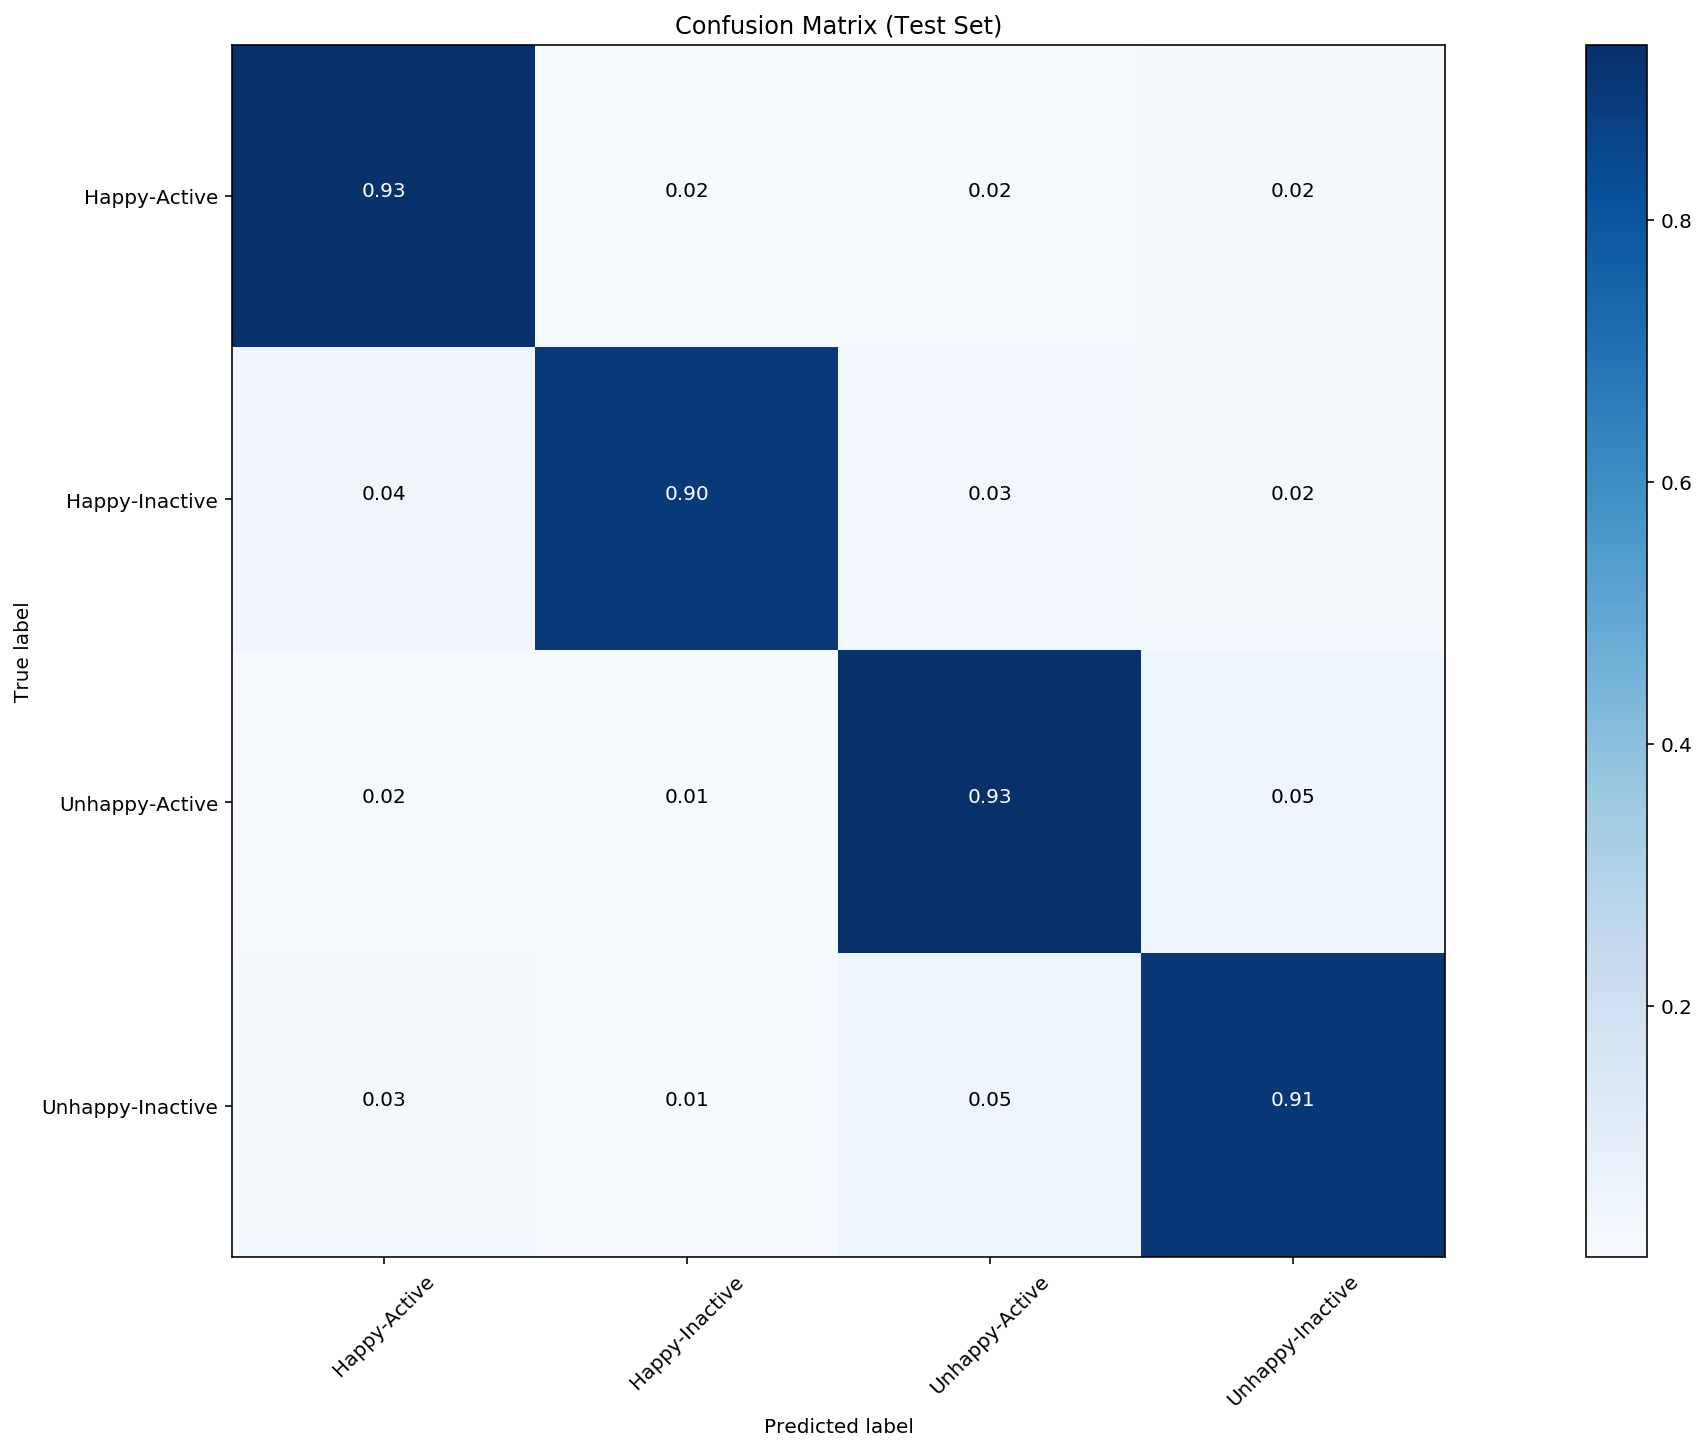

In [19]:

cnf_matrix = confusion_matrix(Y_test, y_prob_class)


def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Test Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

      """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)


# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)


Precision and Recall and F_measure

In [21]:
print(classification_report(Y_test, y_prob_class, target_names=classes ))



                  precision    recall  f1-score   support

    Happy-Active       0.92      0.93      0.93      8178
  Happy-Inactive       0.94      0.90      0.92      6912
  Unhappy-Active       0.91      0.93      0.92      9033
Unhappy-Inactive       0.91      0.91      0.91      8556

     avg / total       0.92      0.92      0.92     32679



In [68]:
"""from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)+1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test,
                                                        y_prob_class)
    average_precision[i] = average_precision_score(Y_test, y_prob_class

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_prob_class.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_prob_class,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))



from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'purple red'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=5)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(labels)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()"""

'from sklearn.metrics import precision_recall_curve\nfrom sklearn.metrics import average_precision_score\n\n# For each class\nprecision = dict()\nrecall = dict()\naverage_precision = dict()\nfor i in range(len(classes)+1):\n    precision[i], recall[i], _ = precision_recall_curve(Y_test,\n                                                        y_prob_class)\n    average_precision[i] = average_precision_score(Y_test, y_prob_class\n\n# A "micro-average": quantifying score on all classes jointly\nprecision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),\n    y_prob_class.ravel())\naverage_precision["micro"] = average_precision_score(Y_test, y_prob_class,\n                                                     average="micro")\nprint(\'Average precision score, micro-averaged over all classes: {0:0.2f}\'\n      .format(average_precision["micro"]))\n\n\n\nfrom itertools import cycle\n# setup plot details\ncolors = cycle([\'navy\', \'turquoise\', \'darkorange\', \'cornflowe

In [34]:
np.array(sequences_test[0])

array([ 39, 225])